* Name: Deepika Ragunatha Krishnan
* Number : N01720823

## Full ML Pipeline - Weather Classification Dataset

## 1. Dataset and Algorithm Selection

* Dataset: weather_classification_data.csv
* Link: https://www.kaggle.com/datasets/nikhil7280/weather-type-classification
* Algorithm: Linear Learner Multi-classification Algorithm

## 2. Initial Installations

In [1]:
! pip install sagemaker botocore boto3 awscli matplotlib seaborn pandas --upgrade

  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 140.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 168.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 159.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 177.2 MB/s eta 0:00:00
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
  Attempting uninstall: botocore
    Found existing installation: botocore 1.37.22
    Uninstalling botocore-1.37.22:
      Successfully uninstalled botocore-1.37.22
  Attempting uninstall: boto3
    Found existing installation: boto3 1

In [2]:
!pip install -U sagemaker

## 3. Import Libraries and necessary dependencies

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import zscore

import boto3
# Import SageMaker estimators
import sagemaker
from sagemaker import get_execution_role
from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.analytics import TrainingJobAnalytics
from sagemaker.tuner import HyperparameterTuner, ContinuousParameter, IntegerParameter, CategoricalParameter
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
from sagemaker.predictor import Predictor
from sagemaker.model import Model
from sagemaker.serverless import ServerlessInferenceConfig

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import Binarizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import io
import time
import json

%matplotlib inline

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:198: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[04/08/25 04:19:58] INFO     Found credentials from IAM Role:                                   ]8;id=998992;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=961886;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


## 4. Sagemaker Session, Role and S3 Configuration

In [5]:
boto_session = boto3.session.Session()
region = boto_session.region_name
print(f"Region: ", region)

sagemaker_session = sagemaker.Session()
base_job_prefix = "Full-ML-Pipeline"
role = sagemaker.get_execution_role()
print(f"Role: ", role)

bucket = 'project-2-drk-cloud'
s3_prefix = base_job_prefix
print(f"Using bucket: {bucket}")

training_instance_type = "ml.m5.xlarge"

Region:  us-east-1


[04/08/25 04:20:09] INFO     Found credentials from IAM Role:                                   ]8;id=95649;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=955940;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

[04/08/25 04:20:10] INFO     Found credentials from IAM Role:                                   ]8;id=779772;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=380700;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

Role:  arn:aws:iam::989629593108:role/fast-ai-academic-22-Student-Azure
Using bucket: project-2-drk-cloud


In [6]:
!aws s3 cp s3://{bucket}/weather_classification_data.csv .

download: s3://project-2-drk-cloud/weather_classification_data.csv to ./weather_classification_data.csv


## 5. Loading Data

In [7]:
df = pd.read_csv('weather_classification_data.csv')
df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,partly cloudy,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,partly cloudy,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,clear,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,clear,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,overcast,990.67,1,Winter,2.5,mountain,Rainy


In [8]:
print("Dataset Size: ", df.shape)
print("The columns in dataset are: \n", df.columns)

Dataset Size:  (13200, 11)
The columns in dataset are: 
 Index(['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)',
       'Cloud Cover', 'Atmospheric Pressure', 'UV Index', 'Season',
       'Visibility (km)', 'Location', 'Weather Type'],
      dtype='object')


## 6. Data - Initial Numerical vs Non-Numerical Analysis

#### There are many nominal columns which needs to be converted to numerical columns for Linear Learner algorithm
## 7. Feature Engineering-I : Conversion of non-numerical to numerical columns

In [9]:
print(df.dtypes)

# Find non-numerical columns
non_numerical_cols = df.select_dtypes(exclude=['number']).columns
print("Non-numerical columns:", non_numerical_cols)

Temperature             float64
Humidity                  int64
Wind Speed              float64
Precipitation (%)       float64
Cloud Cover              object
Atmospheric Pressure    float64
UV Index                  int64
Season                   object
Visibility (km)         float64
Location                 object
Weather Type             object
dtype: object
Non-numerical columns: Index(['Cloud Cover', 'Season', 'Location', 'Weather Type'], dtype='object')


## 8. Feature Engineering-II : Label Encoding for categorical columns that are ordinal

In [10]:
#Data Transformation-1 : Label Encoding
# Define the desired order for 'Cloud Cover'
cloud_cover_order = ['clear', 'partly cloudy', 'cloudy', 'overcast']

# Create a mapping dictionary based on your desired order
cloud_cover_mapping = {value: index for index, value in enumerate(cloud_cover_order)}

# Map 'Cloud Cover' values to integers using the custom mapping
df['Cloud Cover'] = df['Cloud Cover'].map(cloud_cover_mapping)

# Print the custom mapping
print("Cloud Cover mapping:")
for original, encoded in cloud_cover_mapping.items():
    print(f"{original}: {encoded}")
df.head()

Cloud Cover mapping:
clear: 0
partly cloudy: 1
cloudy: 2
overcast: 3


,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Season,Visibility (km),Location,Weather Type
0,14.0,73,9.5,82.0,1,1010.82,2,Winter,3.5,inland,Rainy
1,39.0,96,8.5,71.0,1,1011.43,7,Spring,10.0,inland,Cloudy
2,30.0,64,7.0,16.0,0,1018.72,5,Spring,5.5,mountain,Sunny
3,38.0,83,1.5,82.0,0,1026.25,7,Spring,1.0,coastal,Sunny
4,27.0,74,17.0,66.0,3,990.67,1,Winter,2.5,mountain,Rainy


## 9. Feature Engineering-III: One Hot Encoding for other non-ordinal categorical columns except Target column 
#### - To avoid ordering and give equal priority
## 10. Feature Engineering-IV: Convert True/False into 0/1 to support xgboost algorithm

In [11]:
# Apply One-Hot Encoding for nominal columns (e.g., 'Season', 'Location')
df = pd.get_dummies(df, columns=['Season', 'Location'])

# Replace all True/False values with 1/0
df = df.replace({True: 1, False: 0})

# Verify the changes
print(df.head())

   Temperature  Humidity  Wind Speed  Precipitation (%)  Cloud Cover  \
0         14.0        73         9.5               82.0            1   
1         39.0        96         8.5               71.0            1   
2         30.0        64         7.0               16.0            0   
3         38.0        83         1.5               82.0            0   
4         27.0        74        17.0               66.0            3   

   Atmospheric Pressure  UV Index  Visibility (km) Weather Type  \
0               1010.82         2              3.5        Rainy   
1               1011.43         7             10.0       Cloudy   
2               1018.72         5              5.5        Sunny   
3               1026.25         7              1.0        Sunny   
4                990.67         1              2.5        Rainy   

   Season_Autumn  Season_Spring  Season_Summer  Season_Winter  \
0              0              0              0              1   
1              0              1   

/tmp/ipykernel_13155/1360224177.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({True: 1, False: 0})


## 11. Feature Engineering-V: Target Column - Label Encoding defaultly arranges the ordering alphabetically - Linear Learner doesn't accept manual encoding

In [12]:
# Encode labels
le = LabelEncoder()
df['Weather_Type_Encoded'] = le.fit_transform(df['Weather Type'])

# Store the label mapping for reference
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping:", label_mapping)

# Remove the original 'Weather Type' column
df.drop('Weather Type', axis=1, inplace=True)

# Optionally, you can rename the new column if needed
df.rename(columns={'Weather_Type_Encoded': 'Weather Type'}, inplace=True)

df.head()


Label Mapping: {'Cloudy': 0, 'Rainy': 1, 'Snowy': 2, 'Sunny': 3}


,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Visibility (km),Season_Autumn,Season_Spring,Season_Summer,Season_Winter,Location_coastal,Location_inland,Location_mountain,Weather Type
0,14.0,73,9.5,82.0,1,1010.82,2,3.5,0,0,0,1,0,1,0,1
1,39.0,96,8.5,71.0,1,1011.43,7,10.0,0,1,0,0,0,1,0,0
2,30.0,64,7.0,16.0,0,1018.72,5,5.5,0,1,0,0,0,0,1,3
3,38.0,83,1.5,82.0,0,1026.25,7,1.0,0,1,0,0,1,0,0,3
4,27.0,74,17.0,66.0,3,990.67,1,2.5,0,0,0,1,0,0,1,1


## 12. DataSet - Statistic Analysis

In [13]:
#Data Analysis - Statistics
print(f"DataSet Statistics:")
df.describe()

DataSet Statistics:


,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Visibility (km),Season_Autumn,Season_Spring,Season_Summer,Season_Winter,Location_coastal,Location_inland,Location_mountain,Weather Type
count,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000,13200.000000
mean,19.127576,68.710833,9.832197,53.644394,1.791818,1005.827896,4.005758,5.462917,0.189394,0.196818,0.188788,0.425000,0.270530,0.364848,0.364621,1.500000
std,17.386327,20.194248,6.908704,31.946541,1.188178,37.199589,3.856600,3.371499,0.391836,0.397609,0.391355,0.494362,0.444251,0.481406,0.481342,1.118076
min,-25.000000,20.000000,0.000000,0.000000,0.000000,800.120000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,57.000000,5.000000,19.000000,1.000000,994.800000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.750000
50%,21.000000,70.000000,9.000000,58.000000,1.000000,1007.650000,3.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.500000
75%,31.000000,84.000000,13.500000,82.000000,3.000000,1016.772500,7.000000,7.500000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2.250000
max,109.000000,109.000000,48.500000,109.000000,3.000000,1199.210000,14.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


## 13. Data - Outlier Analysis

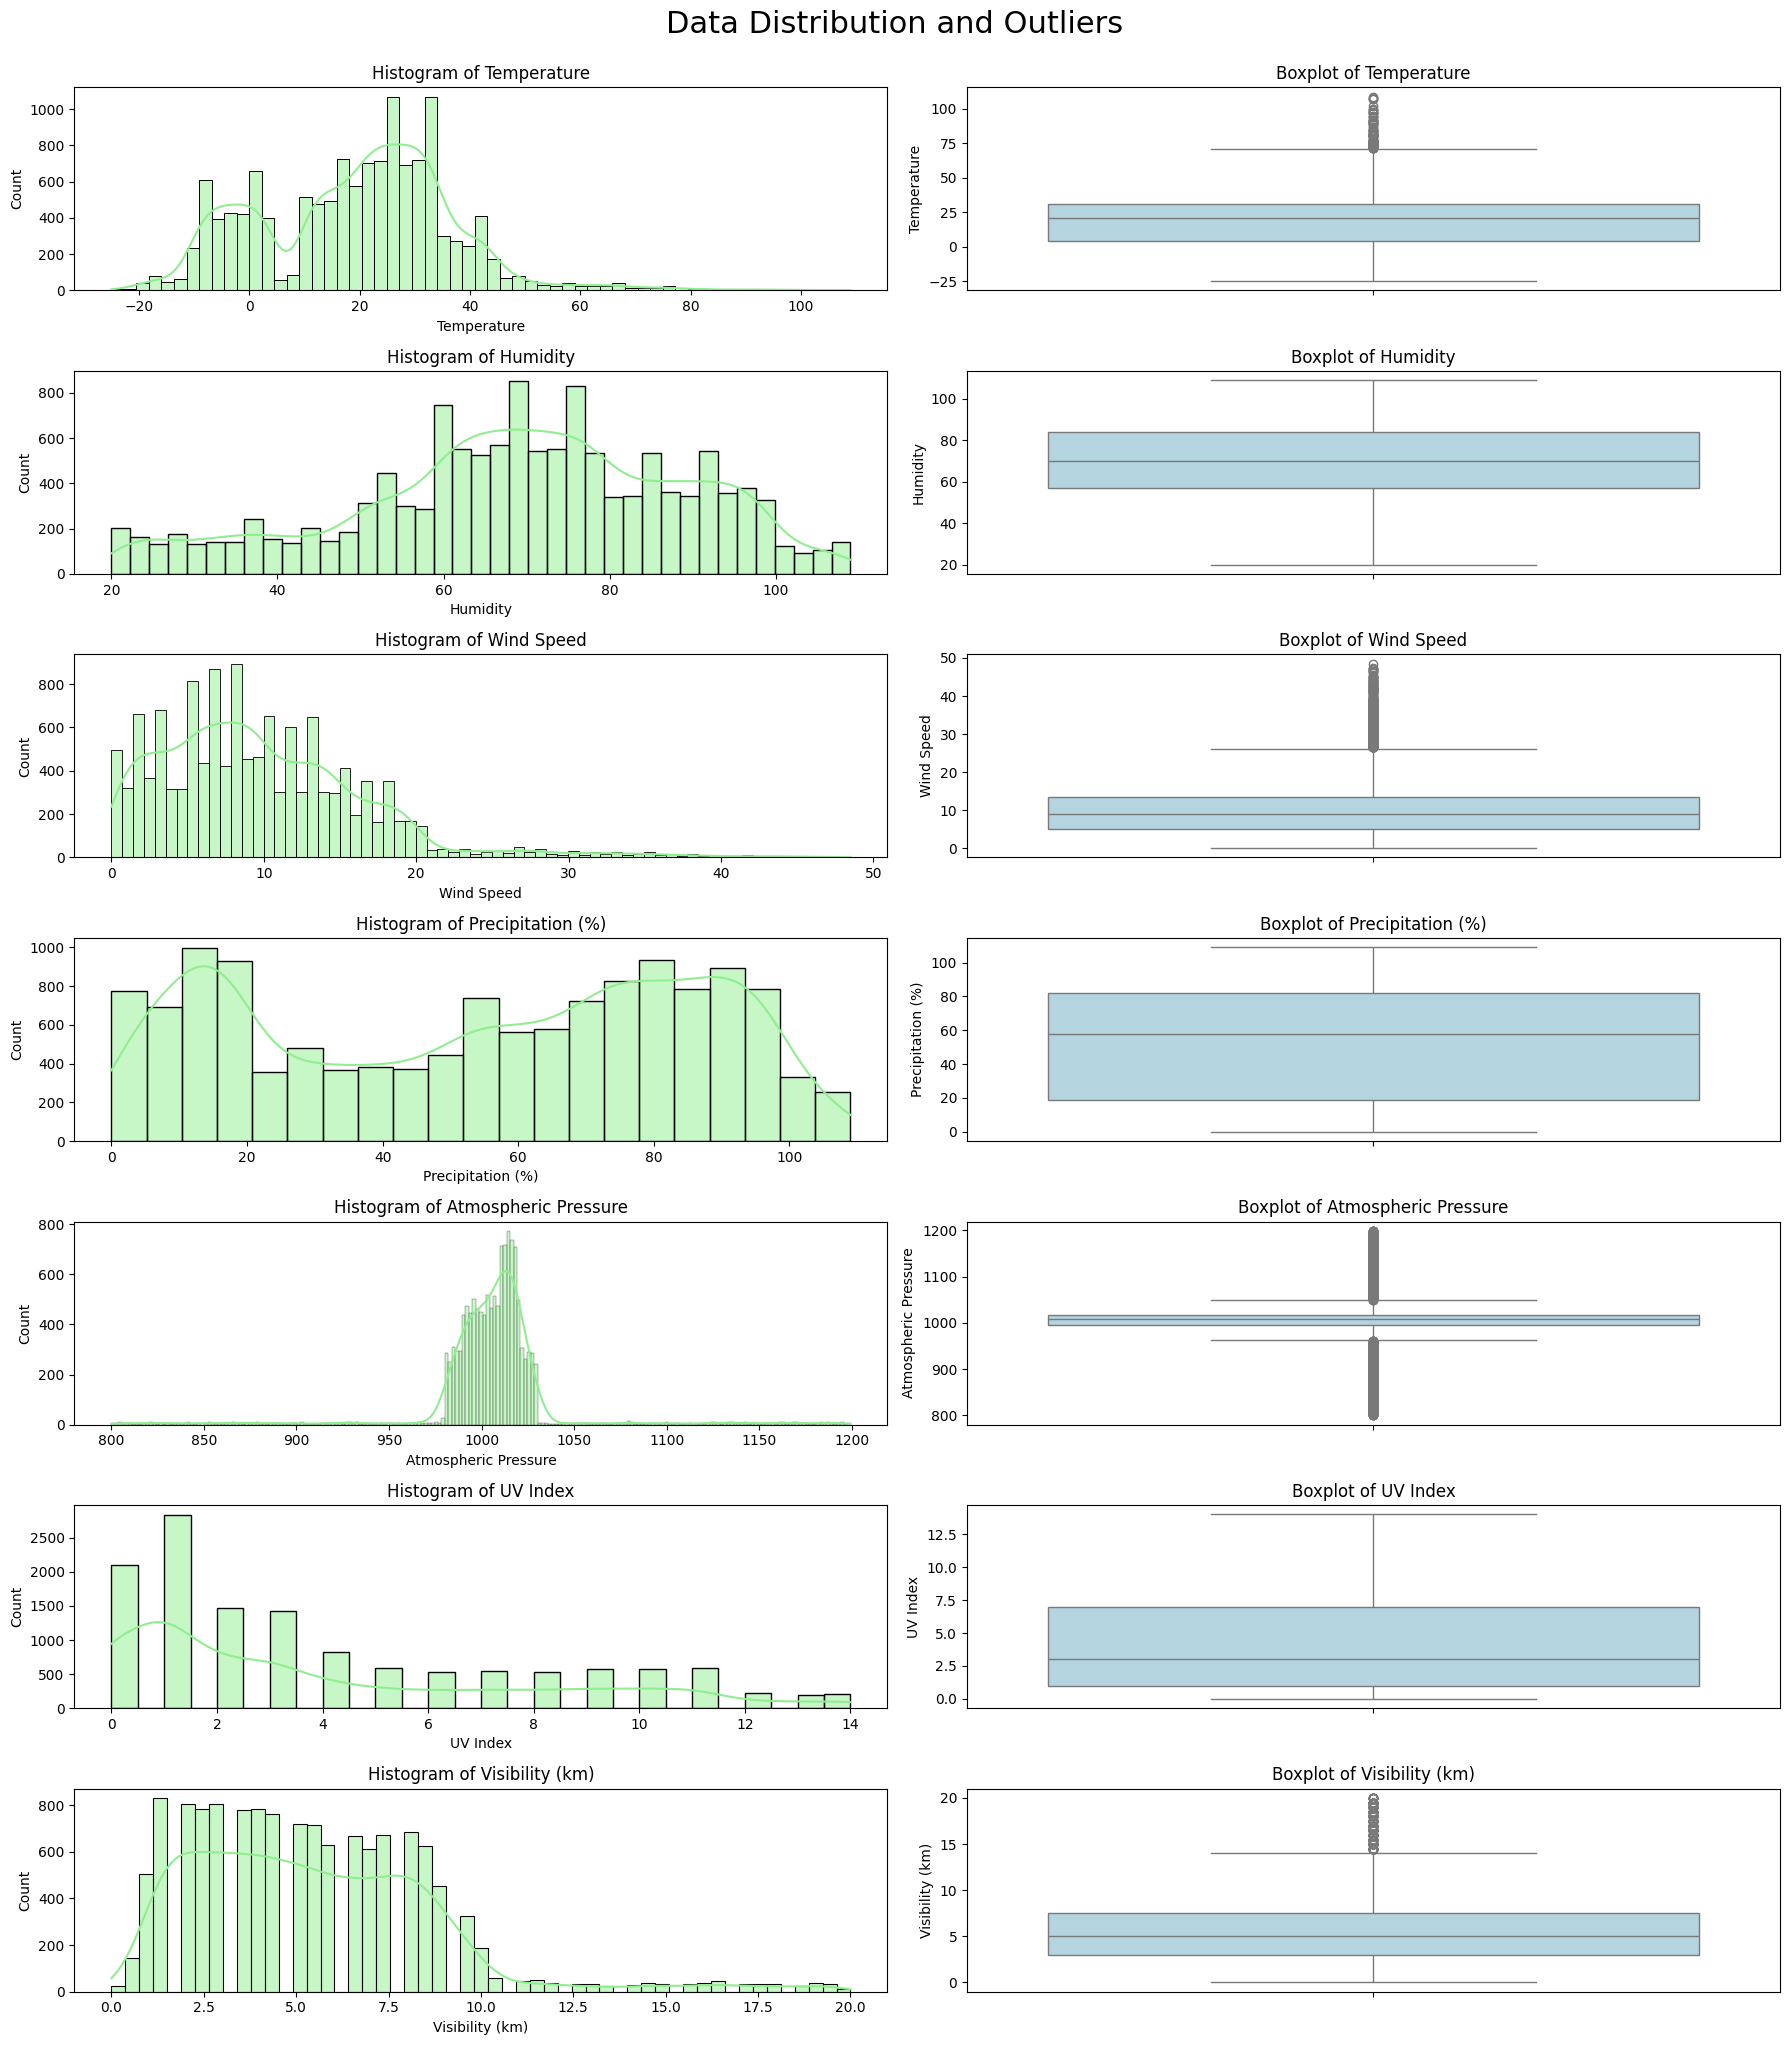

In [14]:
# List of numerical columns
columns_to_check = [
    'Temperature',  'Humidity', 'Wind Speed', 'Precipitation (%)',
    'Atmospheric Pressure', 'UV Index', 'Visibility (km)'
]

# Step 1: Visual Analysis - Histograms + Boxplots
plt.figure(figsize=(18, 20))
for i, col in enumerate(columns_to_check):
    plt.subplot(len(columns_to_check), 2, 2*i+1)
    sns.histplot(df[col], kde=True, color='lightgreen')
    plt.title(f'Histogram of {col}')

    plt.subplot(len(columns_to_check), 2, 2*i+2)
    sns.boxplot(y=df[col], color='lightblue')
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.suptitle("Data Distribution and Outliers", fontsize=22, y=1.02)
plt.show()

## 14. Feature Engineering-VI : Outlier Handling

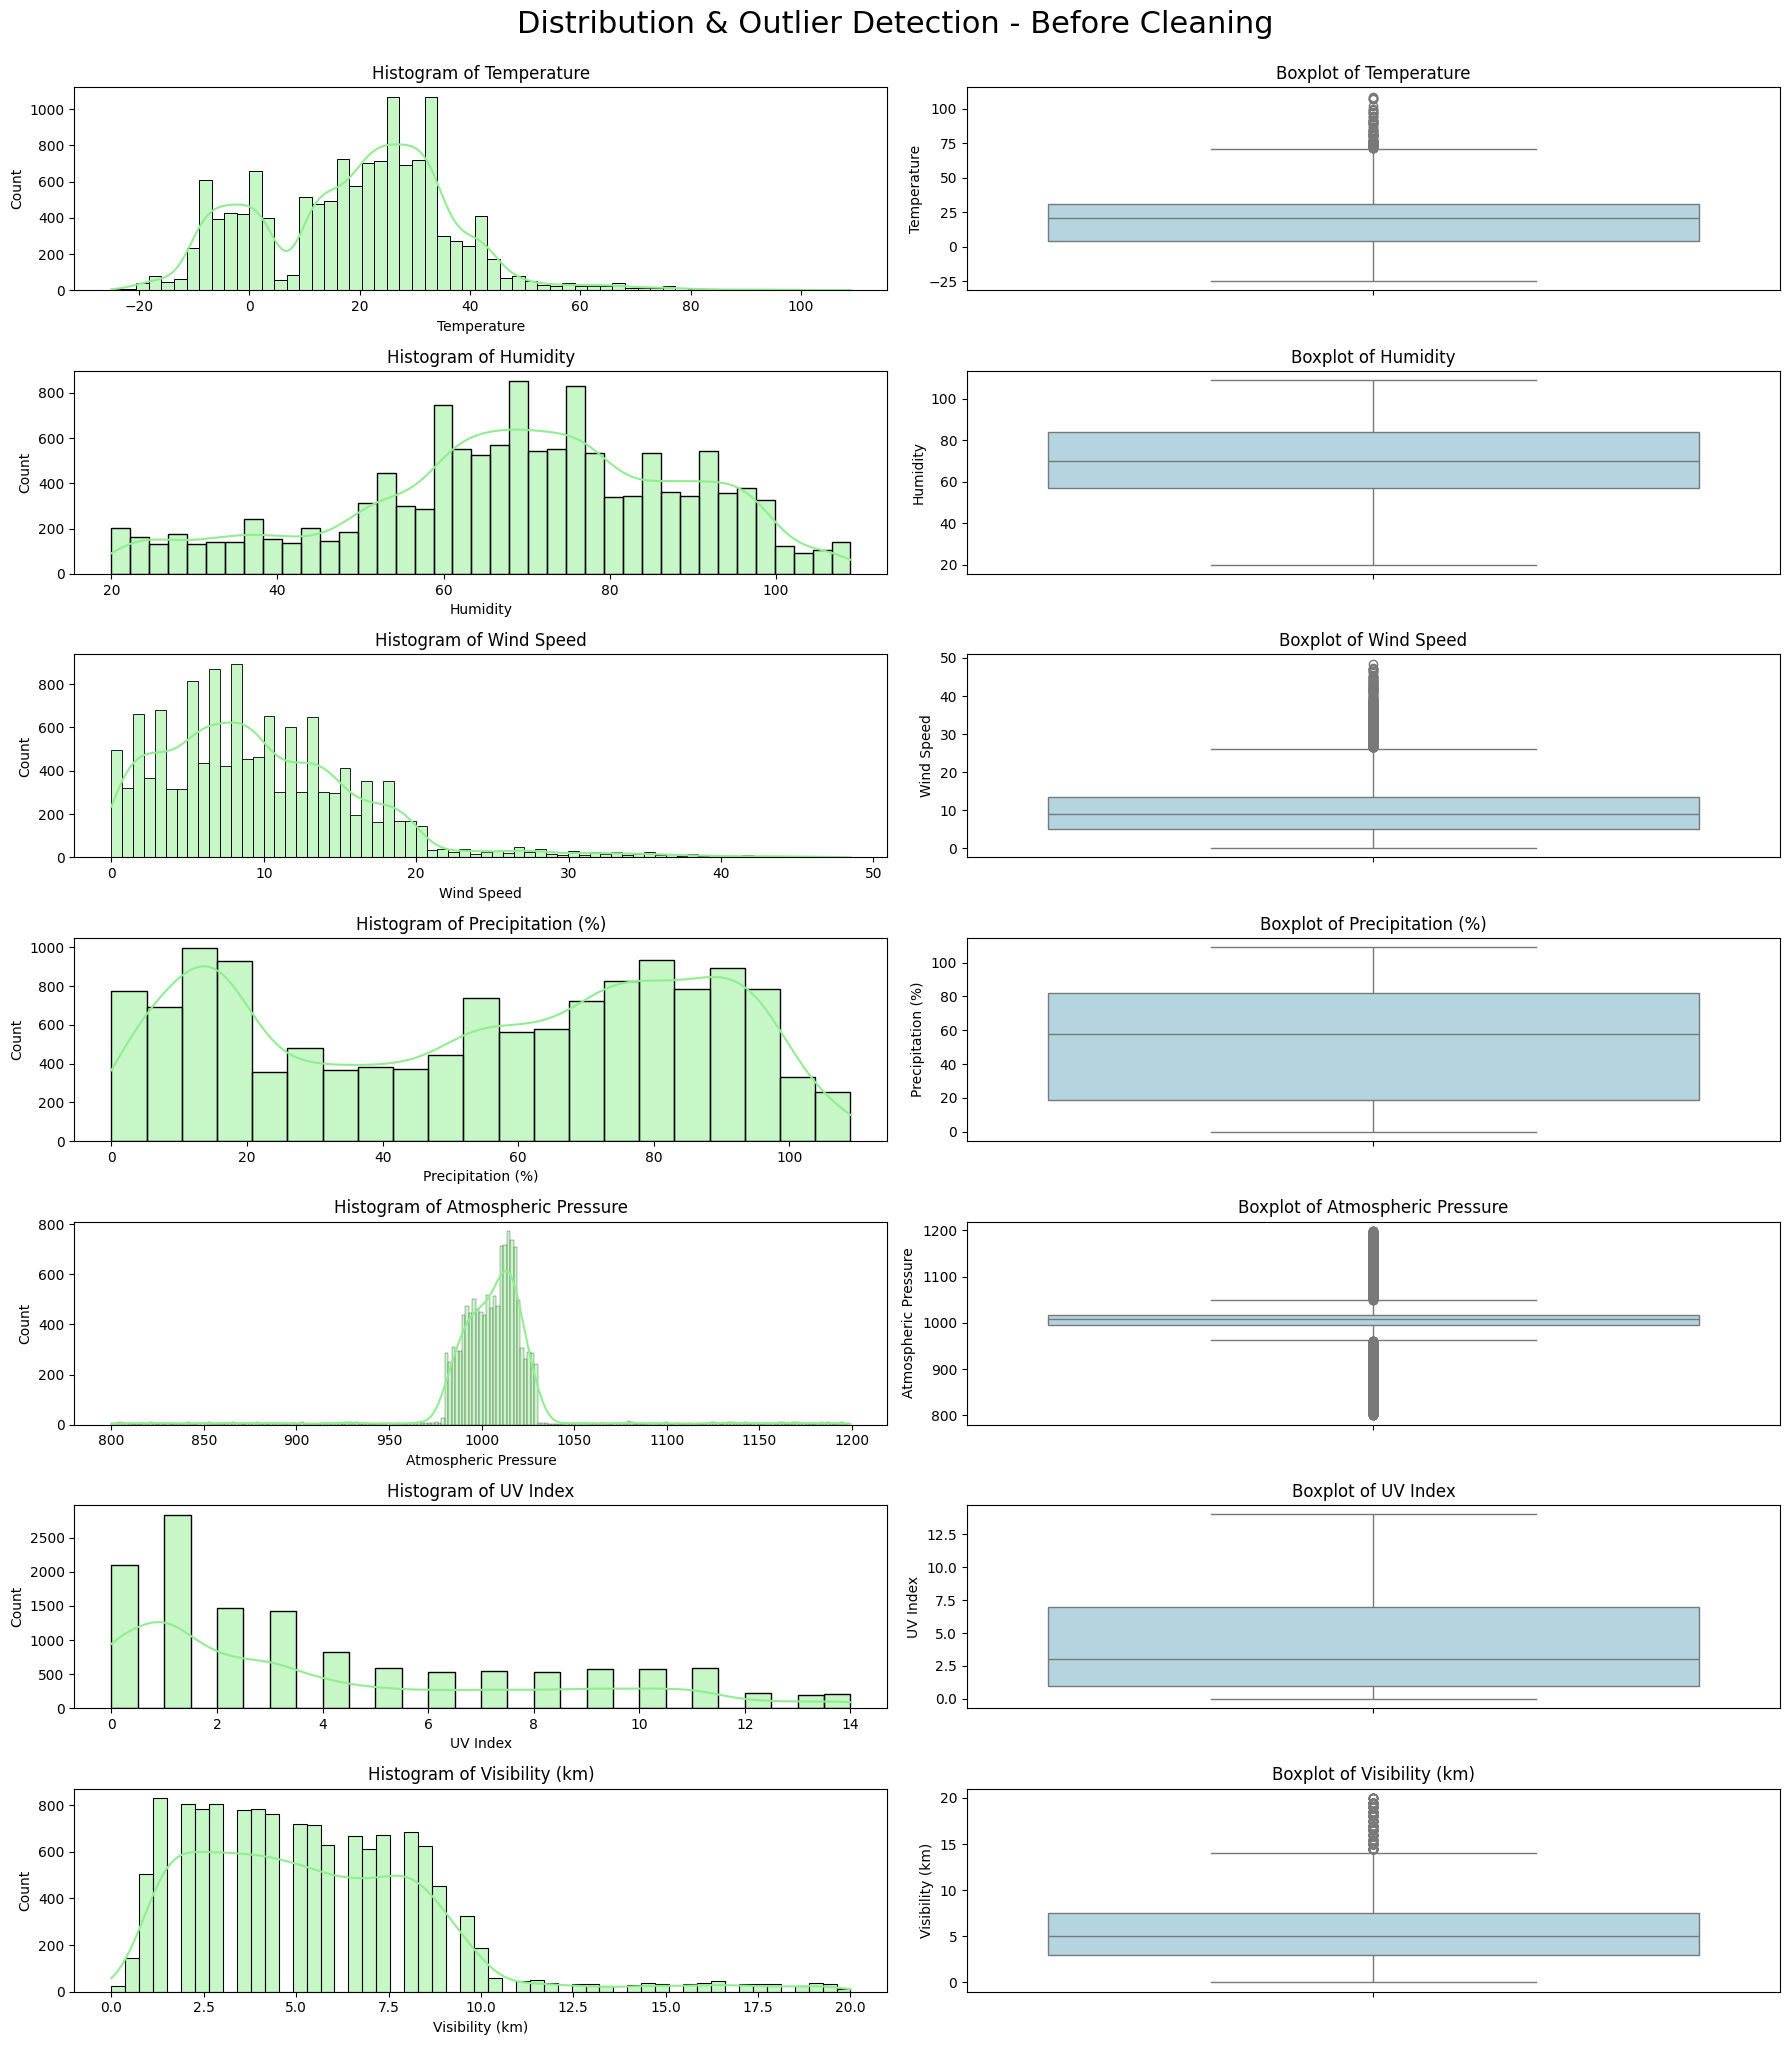


🔍 Analyzing column: 'Temperature'
Skewness of 'Temperature': 0.22
Outliers by IQR: 92
Outliers by Z-Score (>3): 92
✅ Using Z-score for 'Temperature' (data is roughly normal)
   ➤ Outliers removed: 73

🔍 Analyzing column: 'Humidity'
Skewness of 'Humidity': -0.40
Outliers by IQR: 0
Outliers by Z-Score (>3): 0
⚠️ No method assigned for 'Humidity' — skipping

🔍 Analyzing column: 'Wind Speed'
Skewness of 'Wind Speed': 1.36
Outliers by IQR: 404
Outliers by Z-Score (>3): 236
✅ Using IQR for 'Wind Speed' (data is skewed)
   ➤ Outliers removed: 404

🔍 Analyzing column: 'Precipitation (%)'
Skewness of 'Precipitation (%)': -0.15
Outliers by IQR: 0
Outliers by Z-Score (>3): 0
ℹ️ Checking value bounds for 'Precipitation (%)'
✅ Removed 392 rows outside valid range 0–100

🔍 Analyzing column: 'Atmospheric Pressure'
Skewness of 'Atmospheric Pressure': -0.29
Outliers by IQR: 926
Outliers by Z-Score (>3): 552
✅ Using Z-score for 'Atmospheric Pressure' (data is roughly normal)
   ➤ Outliers removed: 239


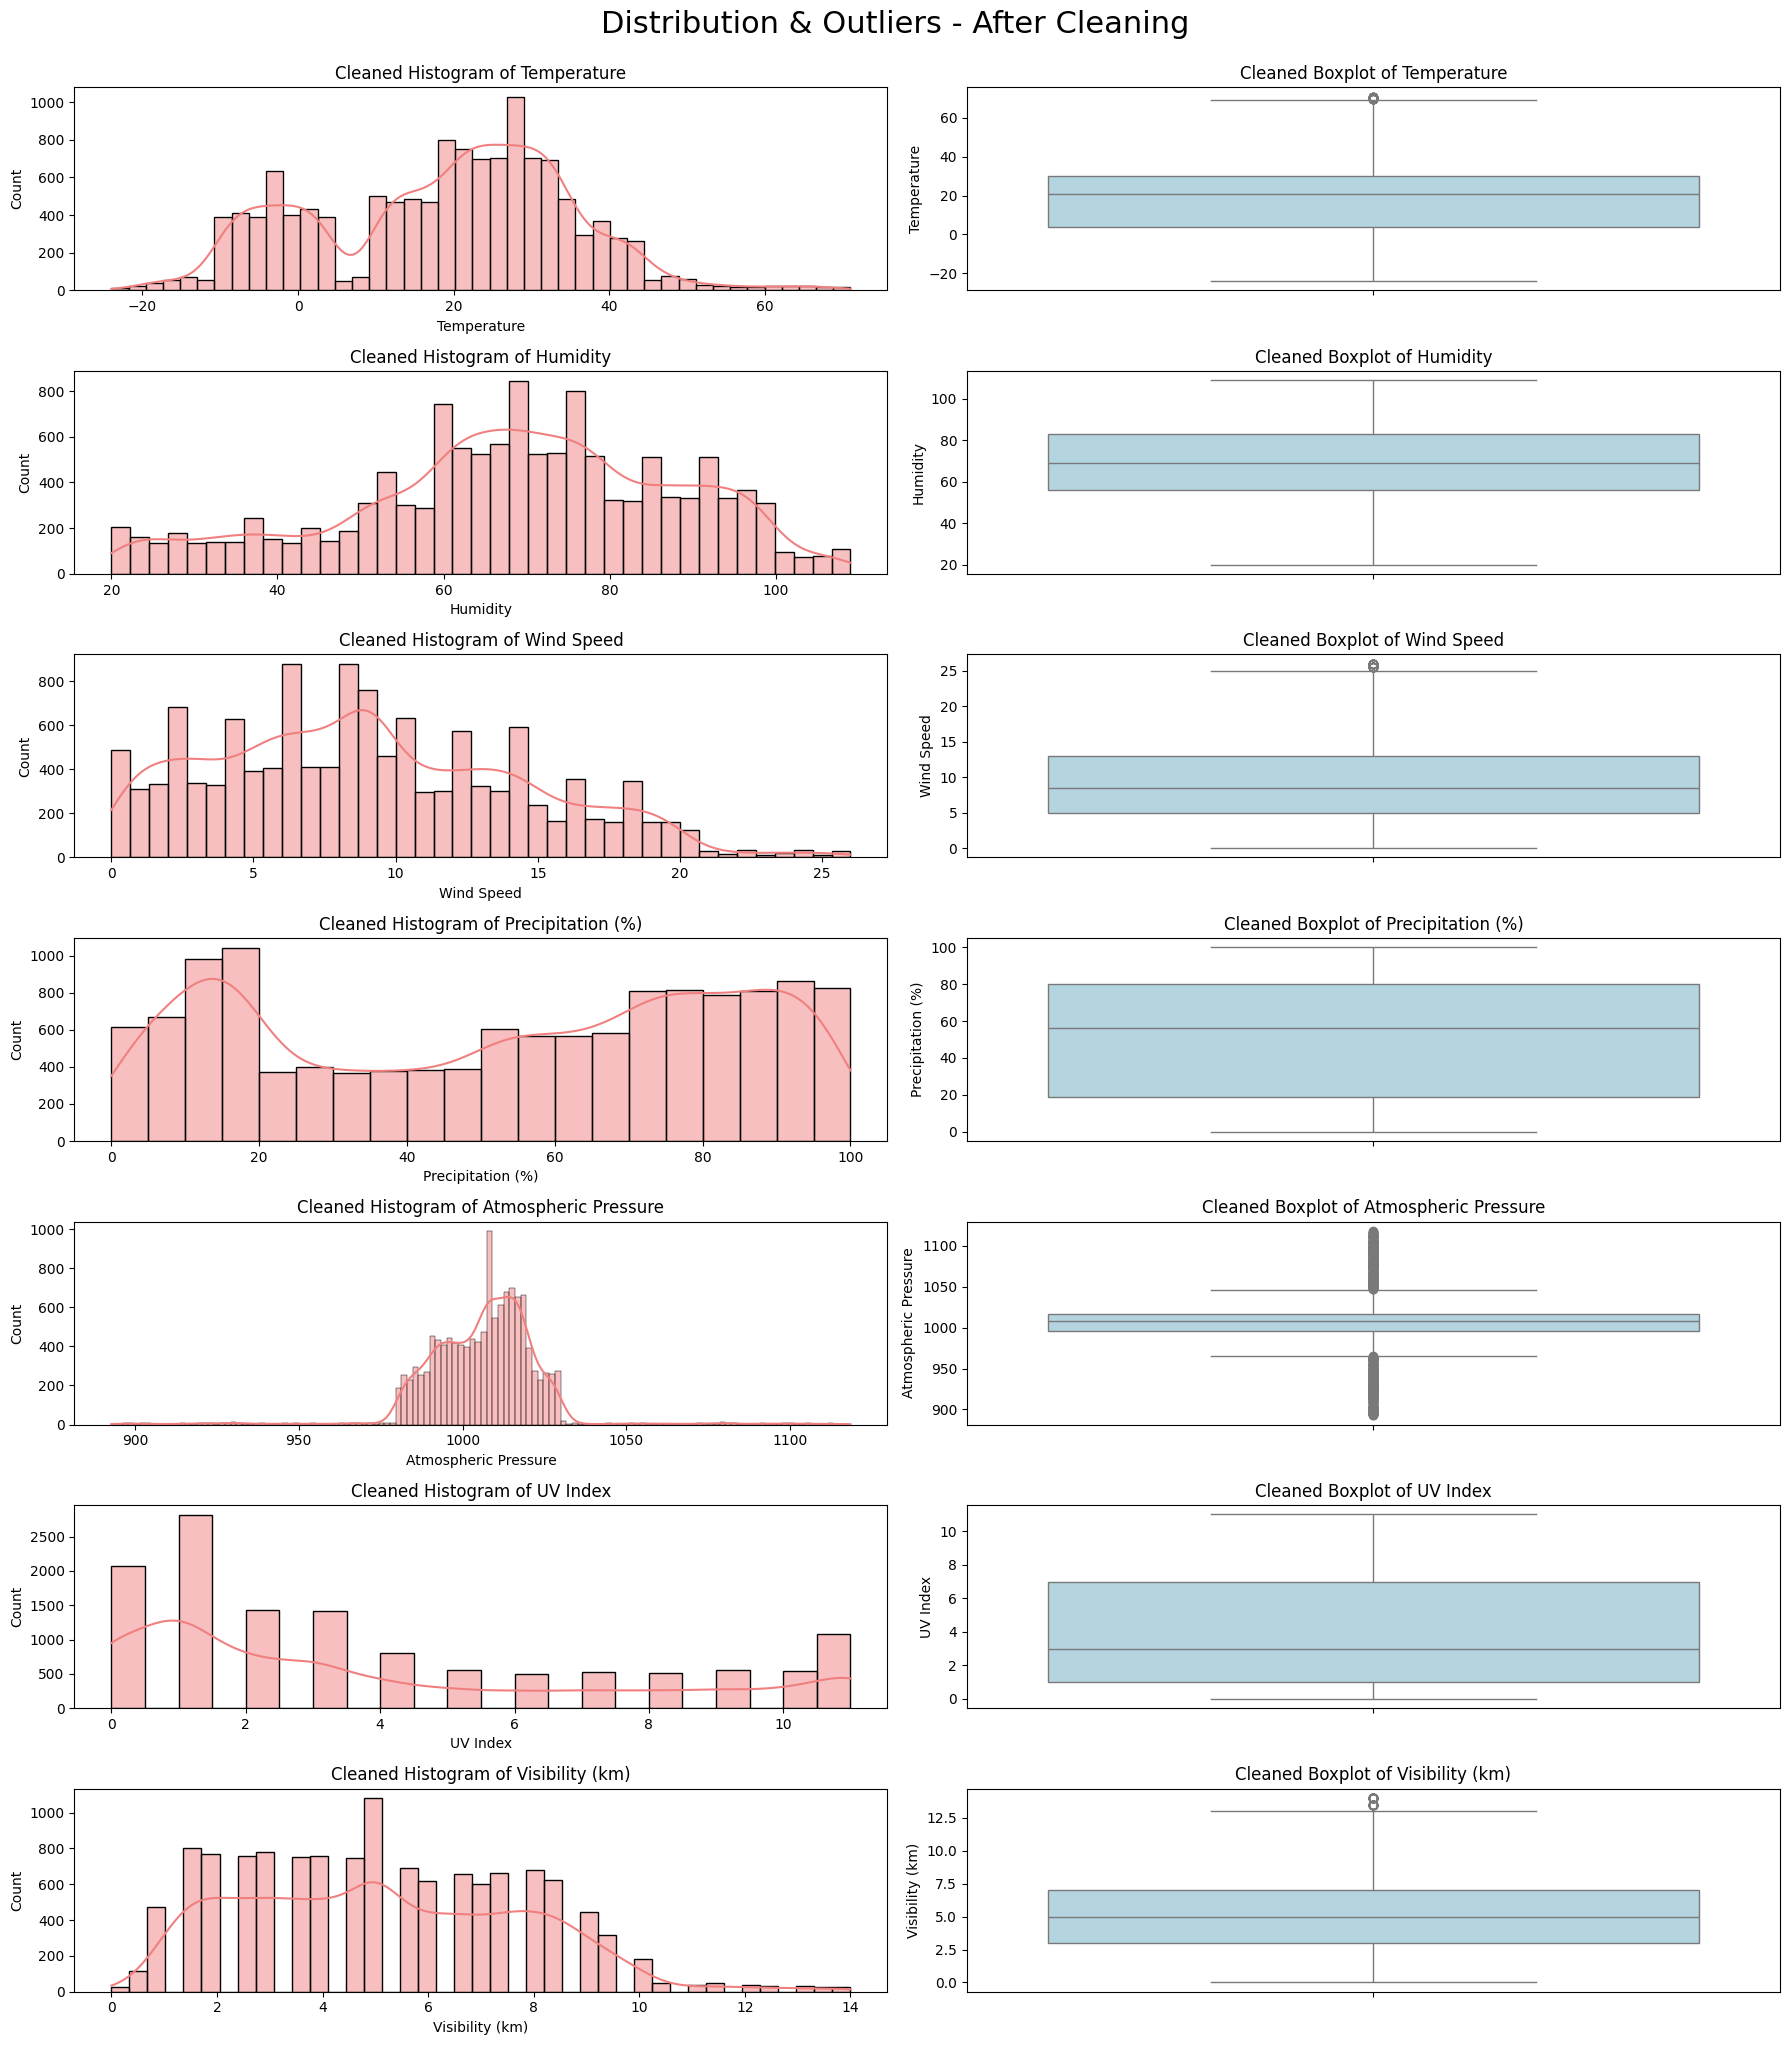

In [15]:
# Select numerical columns to analyze
columns_to_check = [
    'Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)',
    'Atmospheric Pressure', 'UV Index', 'Visibility (km)'
]

# Step 1: Plot Histograms and Boxplots to visually inspect distributions
plt.figure(figsize=(18, 20))
for i, col in enumerate(columns_to_check):
    plt.subplot(len(columns_to_check), 2, 2*i+1)
    sns.histplot(df[col], kde=True, color='lightgreen')
    plt.title(f'Histogram of {col}')

    plt.subplot(len(columns_to_check), 2, 2*i+2)
    sns.boxplot(y=df[col], color='lightblue')
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.suptitle("Distribution & Outlier Detection - Before Cleaning", fontsize=22, y=1.02)
plt.show()

# Step 2: Outlier handling decision, justification, and cleaning
for col in columns_to_check:
    print(f"\n🔍 Analyzing column: '{col}'")
    
    # Calculate skewness to assist in method decision
    skew = df[col].skew()
    print(f"Skewness of '{col}': {skew:.2f}")

    # Initial outlier count using IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    iqr_lower = Q1 - 1.5 * IQR
    iqr_upper = Q3 + 1.5 * IQR
    iqr_outliers = df[(df[col] < iqr_lower) | (df[col] > iqr_upper)]

    # Initial outlier count using Z-score
    z_scores = np.abs(stats.zscore(df[col]))
    zscore_outliers = df[z_scores > 3]

    print(f"Outliers by IQR: {iqr_outliers.shape[0]}")
    print(f"Outliers by Z-Score (>3): {zscore_outliers.shape[0]}")

    # Decision logic
    if col in ['Temperature', 'Atmospheric Pressure']:
        if abs(skew) < 1:
            print(f"✅ Using Z-score for '{col}' (data is roughly normal)")
            before_count = df[(z_scores > 3)].shape[0]
            df[col] = np.where(z_scores > 3, df[col].median(), df[col])
            after_z_scores = np.abs(stats.zscore(df[col]))
            after_count = df[(after_z_scores > 3)].shape[0]
            print(f"   ➤ Outliers removed: {before_count - after_count}")
        else:
            print(f"⚠️ '{col}' is skewed but kept Z-score for simplicity. Review needed.")

    elif col in ['Wind Speed', 'Visibility (km)']:
        if abs(skew) > 1:
            print(f"✅ Using IQR for '{col}' (data is skewed)")
            before_count = iqr_outliers.shape[0]
            df[col] = np.where(df[col] < iqr_lower, df[col].median(), df[col])
            df[col] = np.where(df[col] > iqr_upper, df[col].median(), df[col])
            iqr_outliers_after = df[(df[col] < iqr_lower) | (df[col] > iqr_upper)]
            after_count = iqr_outliers_after.shape[0]
            print(f"   ➤ Outliers removed: {before_count - after_count}")
        else:
            print(f"⚠️ '{col}' is not heavily skewed but still using IQR")

    elif col == 'Precipitation (%)':
        print(f"ℹ️ Checking value bounds for '{col}'")
        before_rows = df.shape[0]
        df = df[(df[col] >= 0) & (df[col] <= 100)]
        after_rows = df.shape[0]
        print(f"✅ Removed {before_rows - after_rows} rows outside valid range 0–100")

    elif col == 'UV Index':
        print(f"✅ Clipping '{col}' to valid range 0–11")
        before_max = df[col].max()
        df[col] = np.clip(df[col], 0, 11)
        after_max = df[col].max()
        print(f"   ➤ Max before: {before_max}, after: {after_max}")

    else:
        print(f"⚠️ No method assigned for '{col}' — skipping")

# Step 3: Plot the cleaned data distributions
plt.figure(figsize=(18, 20))
for i, col in enumerate(columns_to_check):
    plt.subplot(len(columns_to_check), 2, 2*i+1)
    sns.histplot(df[col], kde=True, color='lightcoral')
    plt.title(f'Cleaned Histogram of {col}')

    plt.subplot(len(columns_to_check), 2, 2*i+2)
    sns.boxplot(y=df[col], color='lightblue')
    plt.title(f'Cleaned Boxplot of {col}')

plt.tight_layout()
plt.suptitle("Distribution & Outliers - After Cleaning", fontsize=22, y=1.02)
plt.show()


## 15. Data Analysis - Duplicate and Missing Value Check

In [16]:
# Check for duplicate rows
duplicate_rows = df[df.duplicated()]

# Print the number of duplicate rows
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")

# Check for missing values
missing_values = df.isnull().sum()

print("Number of Missing Values : ", missing_values.sum())
# Print missing values for each column
print("Missing Values in Each Column:")
print(missing_values[missing_values > 0])

Number of duplicate rows: 0
Number of Missing Values :  0
Missing Values in Each Column:
Series([], dtype: int64)


## 16. Data Analysis - Frequency of Weather Types

In [17]:
df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Visibility (km),Season_Autumn,Season_Spring,Season_Summer,Season_Winter,Location_coastal,Location_inland,Location_mountain,Weather Type
0,14.0,73,9.5,82.0,1,1010.82,2,3.5,0,0,0,1,0,1,0,1
1,39.0,96,8.5,71.0,1,1011.43,7,10.0,0,1,0,0,0,1,0,0
2,30.0,64,7.0,16.0,0,1018.72,5,5.5,0,1,0,0,0,0,1,3
3,38.0,83,1.5,82.0,0,1026.25,7,1.0,0,1,0,0,1,0,0,3
4,27.0,74,17.0,66.0,3,990.67,1,2.5,0,0,0,1,0,0,1,1


🌦️ Frequency of Each Weather Type:
 - Cloudy: 3197 rows
 - Rainy: 3191 rows
 - Snowy: 3211 rows
 - Sunny: 3209 rows


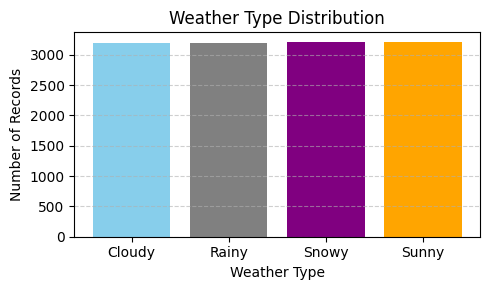

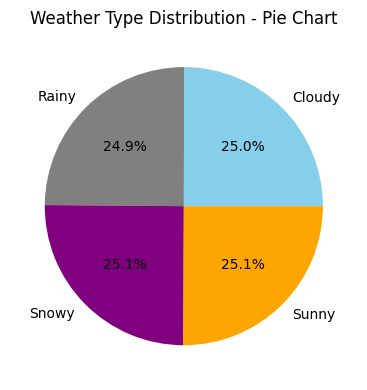

In [18]:
reverse_mapping = {v: k for k, v in label_mapping.items()}

# 2. Get value counts from the encoded "Weather Type" column
weather_counts = df["Weather Type"].value_counts().sort_index()

# 3. Decode the counts to original weather labels
decoded_counts = {reverse_mapping[i]: count for i, count in weather_counts.items()}

# 4. Print weather distribution
print("🌦️ Frequency of Each Weather Type:")
for label, count in decoded_counts.items():
    print(f" - {label}: {count} rows")

# 5. Bar Chart
plt.figure(figsize=(5, 3))
plt.bar(decoded_counts.keys(), decoded_counts.values(), color=['skyblue', 'gray', 'purple', 'orange'])
plt.title("Weather Type Distribution")
plt.xlabel("Weather Type")
plt.ylabel("Number of Records")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 6. Pie Chart
plt.figure(figsize=(4, 4))
plt.pie(decoded_counts.values(), labels=decoded_counts.keys(), autopct='%1.1f%%', colors=['skyblue', 'gray', 'purple', 'orange'])
plt.title("Weather Type Distribution - Pie Chart")
plt.tight_layout()
plt.show()

In [19]:
df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Visibility (km),Season_Autumn,Season_Spring,Season_Summer,Season_Winter,Location_coastal,Location_inland,Location_mountain,Weather Type
0,14.0,73,9.5,82.0,1,1010.82,2,3.5,0,0,0,1,0,1,0,1
1,39.0,96,8.5,71.0,1,1011.43,7,10.0,0,1,0,0,0,1,0,0
2,30.0,64,7.0,16.0,0,1018.72,5,5.5,0,1,0,0,0,0,1,3
3,38.0,83,1.5,82.0,0,1026.25,7,1.0,0,1,0,0,1,0,0,3
4,27.0,74,17.0,66.0,3,990.67,1,2.5,0,0,0,1,0,0,1,1


## 17. Data - Correlation Analysis 
#### - To find which features account for target prediction most

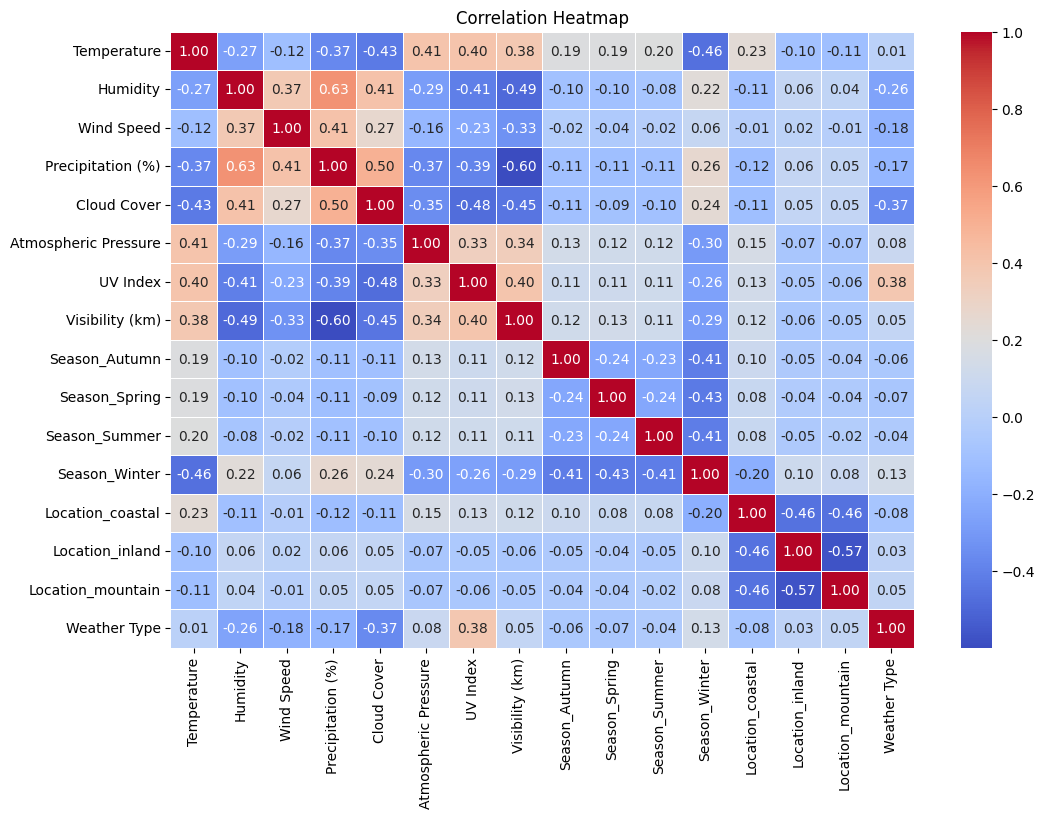

Weather Type            1.000000
UV Index                0.381441
Season_Winter           0.133707
Atmospheric Pressure    0.084063
Visibility (km)         0.050636
Location_mountain       0.045947
Location_inland         0.025869
Temperature             0.013924
Season_Summer          -0.041649
Season_Autumn          -0.057360
Season_Spring          -0.068685
Location_coastal       -0.077802
Precipitation (%)      -0.167795
Wind Speed             -0.181433
Humidity               -0.256860
Cloud Cover            -0.368328
Name: Weather Type, dtype: float64


In [20]:
correlation_matrix = df.corr()

# Plotting the heatmap of correlation
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

# Identifying the correlation with the target variable (Weather Type)
target_correlation = correlation_matrix['Weather Type'].sort_values(ascending=False)
print(target_correlation)

In [21]:
df.head()

,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Visibility (km),Season_Autumn,Season_Spring,Season_Summer,Season_Winter,Location_coastal,Location_inland,Location_mountain,Weather Type
0,14.0,73,9.5,82.0,1,1010.82,2,3.5,0,0,0,1,0,1,0,1
1,39.0,96,8.5,71.0,1,1011.43,7,10.0,0,1,0,0,0,1,0,0
2,30.0,64,7.0,16.0,0,1018.72,5,5.5,0,1,0,0,0,0,1,3
3,38.0,83,1.5,82.0,0,1026.25,7,1.0,0,1,0,0,1,0,0,3
4,27.0,74,17.0,66.0,3,990.67,1,2.5,0,0,0,1,0,0,1,1


## 18. Feature Engineering-VII : Standardization, MinMax Scaling, ZScore Normalization & IQR based outlier transformation

In [22]:
# Apply Standard Scaler to 'Temperature' (normally distributed)
scaler = StandardScaler()
df['Temperature_scaled'] = scaler.fit_transform(df[['Temperature']])
print("Standardized Temperature column")

# Apply Min-Max Scaler to 'Wind Speed' (skewed distribution)
min_max_scaler = MinMaxScaler()
df['Wind Speed_scaled'] = min_max_scaler.fit_transform(df[['Wind Speed']])
print("Min-Max scaled Wind Speed")

# Z-Score for normally distributed features (e.g., Atmospheric Pressure)
df['Atmospheric Pressure_zscore'] = zscore(df['Atmospheric Pressure'])
print("Z-score for Atmospheric Pressure")

# Clipping for UV Index (outliers beyond the valid range)
df['UV Index_clipped'] = np.clip(df['UV Index'], 0, 11)
print("Clipped UV Index")

# IQR method for Visibility (skewed data)
Q1 = df['Visibility (km)'].quantile(0.25)
Q3 = df['Visibility (km)'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df['Visibility_filtered'] = df['Visibility (km)'].apply(lambda x: x if lower_bound <= x <= upper_bound else np.nan)
df['Visibility_filtered'].fillna(df['Visibility_filtered'].median(), inplace=True)
print("Filtered Visibility with IQR")

Standardized Temperature column
Min-Max scaled Wind Speed
Z-score for Atmospheric Pressure
Clipped UV Index
Filtered Visibility with IQR


/tmp/ipykernel_13155/84493679.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Visibility_filtered'].fillna(df['Visibility_filtered'].median(), inplace=True)


In [23]:
# No further transformations necessary for Precipitation (%)
print("Precipitation (%) and Humidity is already within the valid range, no further transformation needed.")
df.head()

Precipitation (%) and Humidity is already within the valid range, no further transformation needed.


,Temperature,Humidity,Wind Speed,Precipitation (%),Cloud Cover,Atmospheric Pressure,UV Index,Visibility (km),Season_Autumn,Season_Spring,...,Season_Winter,Location_coastal,Location_inland,Location_mountain,Weather Type,Temperature_scaled,Wind Speed_scaled,Atmospheric Pressure_zscore,UV Index_clipped,Visibility_filtered
0,14.0,73,9.5,82.0,1,1010.82,2,3.5,0,0,...,1,0,1,0,1,-0.277472,0.365385,0.252703,2,3.5
1,39.0,96,8.5,71.0,1,1011.43,7,10.0,0,1,...,0,0,1,0,0,1.252915,0.326923,0.285455,7,10.0
2,30.0,64,7.0,16.0,0,1018.72,5,5.5,0,1,...,0,0,0,1,3,0.701976,0.269231,0.676867,5,5.5
3,38.0,83,1.5,82.0,0,1026.25,7,1.0,0,1,...,0,1,0,0,3,1.191700,0.057692,1.081165,7,1.0
4,27.0,74,17.0,66.0,3,990.67,1,2.5,0,0,...,1,0,0,1,1,0.518329,0.653846,-0.829182,1,2.5


In [24]:
df.columns

Index(['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)',
       'Cloud Cover', 'Atmospheric Pressure', 'UV Index', 'Visibility (km)',
       'Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Location_coastal', 'Location_inland', 'Location_mountain',
       'Weather Type', 'Temperature_scaled', 'Wind Speed_scaled',
       'Atmospheric Pressure_zscore', 'UV Index_clipped',
       'Visibility_filtered'],
      dtype='object')

## 19. Preprocessed Data Creation

In [25]:
# Columns to be included after transformation
features = [
    'Temperature_scaled', 'Humidity', 'Wind Speed_scaled', 'Precipitation (%)', 'Cloud Cover',
    'Atmospheric Pressure_zscore', 'UV Index_clipped', 'Visibility_filtered',
    'Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Winter', 
    'Location_coastal', 'Location_inland', 'Location_mountain'
]

# Target column
target = 'Weather Type'

# Create the feature matrix (X) and target vector (y)
X = df[features]
y = df[target]

# Check for NaN values in the selected features and target column
print("NaN values in features:")
print(X.isnull().sum())  # Check NaNs in feature columns

print("NaN values in target column:")
print(y.isnull().sum())  # Check NaNs in target column

# Combine features and target to save as preprocessed data
preprocessed_data = X.copy()
preprocessed_data[target] = y

# Save the preprocessed data
preprocessed_data.to_csv('preprocessed_linear_data.csv', index=False)

# Display the preprocessed dataframe to confirm
print(preprocessed_data.head())

NaN values in features:
Temperature_scaled             0
Humidity                       0
Wind Speed_scaled              0
Precipitation (%)              0
Cloud Cover                    0
Atmospheric Pressure_zscore    0
UV Index_clipped               0
Visibility_filtered            0
Season_Autumn                  0
Season_Spring                  0
Season_Summer                  0
Season_Winter                  0
Location_coastal               0
Location_inland                0
Location_mountain              0
dtype: int64
NaN values in target column:
0
   Temperature_scaled  Humidity  Wind Speed_scaled  Precipitation (%)  \
0           -0.277472        73           0.365385               82.0   
1            1.252915        96           0.326923               71.0   
2            0.701976        64           0.269231               16.0   
3            1.191700        83           0.057692               82.0   
4            0.518329        74           0.653846               66.0   

## 20. S3 Upload : Preprocessed Data Set

In [28]:
# Upload the file to S3
s3_client = boto3.client('s3')
s3_client.upload_file('preprocessed_linear_data.csv', bucket, f"{s3_prefix}/preprocessed_linear_data.csv")

In [29]:
print("Columns: \n", preprocessed_data.columns)
preprocessed_data.shape

Columns: 
 Index(['Temperature_scaled', 'Humidity', 'Wind Speed_scaled',
       'Precipitation (%)', 'Cloud Cover', 'Atmospheric Pressure_zscore',
       'UV Index_clipped', 'Visibility_filtered', 'Season_Autumn',
       'Season_Spring', 'Season_Summer', 'Season_Winter', 'Location_coastal',
       'Location_inland', 'Location_mountain', 'Weather Type'],
      dtype='object')


(12808, 16)

## 21. Training & Testing Data Split

In [65]:
# Split data into train and test sets
# First, split into 70% train_val and 30% test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Now split train_val into 90% train and 10% val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1, random_state=42, stratify=y_train_val
)

# Concatenate labels in the first column (Linear Learner expects label first)
train_data = pd.concat([y_train, X_train], axis=1)  # Label comes first for Linear Learner
val_data = pd.concat([y_val, X_val], axis=1)  # Label comes first for Linear Learner
test_data = pd.concat([y_test, X_test], axis=1)  # Label comes first for Linear Learner

# Save to CSVs (no headers for SageMaker Linear Learner)
train_data.to_csv("train_linear.csv", index=False, header=False)
val_data.to_csv("validation_linear.csv", index=False, header=False)
test_data.to_csv("test_linear.csv", index=False, header=True)

print("Splitting complete ✅")
# Print the shape of each dataset
print("Training set shape:    ", train_data.shape)
print("Validation set shape:  ", val_data.shape)
print("Test set shape:        ", test_data.shape)

Splitting complete ✅
Training set shape:     (8068, 16)
Validation set shape:   (897, 16)
Test set shape:         (3843, 16)


In [31]:
print(train_data.head())

# In Linear, label is the first column
unique_labels = train_data.iloc[:, 0].unique()
print("Unique labels in test data:", unique_labels)

       Weather Type  Temperature_scaled  Humidity  Wind Speed_scaled  \
9788              3            0.457114        26           0.326923   
9349              3            1.130484        66           0.307692   
3591              3            1.375346        54           0.346154   
6188              3            1.130484        25           0.096154   
12424             3            0.763191        27           0.384615   

       Precipitation (%)  Cloud Cover  Atmospheric Pressure_zscore  \
9788                14.0            0                     1.167608   
9349                13.0            0                     0.590960   
3591                 4.0            1                     0.400355   
6188                12.0            1                     0.634451   
12424                1.0            0                     1.138615   

       UV Index_clipped  Visibility_filtered  Season_Autumn  Season_Spring  \
9788                  5                  6.5              0         

In [32]:
print(test_data.head())

# In Linear label is the first column
unique_labels = test_data.iloc[:, 0].unique()
print("Unique labels in test data:", unique_labels)

      Weather Type  Temperature_scaled  Humidity  Wind Speed_scaled  \
270              2           -1.379352        69           0.557692   
2924             0            0.334683        59           0.403846   
1218             3            1.130484        86           0.346154   
6076             0           -0.155041        57           0.173077   
7286             3            0.763191        57           0.057692   

      Precipitation (%)  Cloud Cover  Atmospheric Pressure_zscore  \
270                56.0            3                    -0.621933   
2924               28.0            1                     0.145857   
1218               93.0            0                     0.631229   
6076               43.0            1                    -0.063540   
7286               89.0            1                     0.153374   

      UV Index_clipped  Visibility_filtered  Season_Autumn  Season_Spring  \
270                  1                  3.0              0              0   
2924

In [33]:
#print("Unique labels in X_train:", X_train.unique())
#print("Unique labels in X_test:", X_test.unique())
print("Unique labels in y_train:", y_train.unique())
print("Unique labels in y_test:", y_test.unique())

Unique labels in y_train: [3 1 0 2]
Unique labels in y_test: [2 0 3 1]


In [34]:
y_train.dtype

dtype('int64')

In [35]:
print(X_train.dtypes)
print()
print(y_train.dtypes)

Temperature_scaled             float64
Humidity                         int64
Wind Speed_scaled              float64
Precipitation (%)              float64
Cloud Cover                      int64
Atmospheric Pressure_zscore    float64
UV Index_clipped                 int64
Visibility_filtered            float64
Season_Autumn                    int64
Season_Spring                    int64
Season_Summer                    int64
Season_Winter                    int64
Location_coastal                 int64
Location_inland                  int64
Location_mountain                int64
dtype: object

int64


## 22. S3 Upload : Train and Test Data

In [36]:
s3_train_path = sagemaker_session.upload_data("train_linear.csv", bucket=bucket, key_prefix=f"{s3_prefix}/weather-linear/train")
s3_validation_path = sagemaker_session.upload_data("validation_linear.csv", bucket=bucket, key_prefix=f"{s3_prefix}/weather-linear/validation")
s3_test_path = sagemaker_session.upload_data("test_linear.csv", bucket=bucket, key_prefix=f"{s3_prefix}/weather-linear/test")

print("S3 Train Path:", s3_train_path)
print("S3 Validation Path: ", s3_validation_path)
print("S3 Test Path:", s3_test_path)


S3 Train Path: s3://project-2-drk-cloud/Full-ML-Pipeline/weather-linear/train/train_linear.csv
S3 Validation Path:  s3://project-2-drk-cloud/Full-ML-Pipeline/weather-linear/validation/validation_linear.csv
S3 Test Path: s3://project-2-drk-cloud/Full-ML-Pipeline/weather-linear/test/test_linear.csv


## 23. Training Job - Configuration

In [37]:
# Create TrainingInput for the training data
train_input = TrainingInput(s3_train_path, content_type="text/csv")
val_input = TrainingInput(s3_test_path, content_type="text/csv")


In [38]:
# Configuration
s3_sub_prefix = 'weather-classification'
model_path = f"s3://{bucket}/{s3_prefix}/{s3_sub_prefix}/linear_model"

# Retrieve XGBoost image
linear_image_uri = sagemaker.image_uris.retrieve(
    framework="linear-learner",
    region=region,
    instance_type=training_instance_type,
)

# Configure Training Estimator
linear_estimator = sagemaker.estimator.Estimator(
    image_uri=linear_image_uri,
    instance_type=training_instance_type,
    instance_count=1,
    output_path=model_path,
    sagemaker_session=sagemaker_session,
    role=role,
)

[04/08/25 04:28:03] INFO     Same images used for training and inference. Defaulting to image     ]8;id=351145;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=924121;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: ml.m5.xlarge.                    ]8;id=751269;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=925436;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

## 24. Training Job - Hyperparameter Configuration

In [39]:
# Set Hyperparameters for Classification
linear_estimator.set_hyperparameters(
    predictor_type="multiclass_classifier",  # For multi-class classification
    num_classes=4,  # Number of weather classes
    mini_batch_size=100,
    #early_stopping_rounds=10, # Stop if validation doesn't improve for 10 rounds
    epochs=20,
    use_bias=True
)

In [40]:
df_train = pd.read_csv("train_linear.csv", header=None)  # assuming no header
print(df_train.head())

# The target column should be the first column in the dataset
labels = df_train.iloc[:, 0]  # first column
print("Unique labels:", labels.unique())
print("Label dtype:", labels.dtype)


   0         1   2         3     4   5         6   7    8   9   10  11  12  \
0   3  0.457114  26  0.326923  14.0   0  1.167608   5  6.5   0   0   1   0   
1   3  1.130484  66  0.307692  13.0   0  0.590960   7  9.5   0   0   0   1   
2   3  1.375346  54  0.346154   4.0   1  0.400355  11  6.0   1   0   0   0   
3   3  1.130484  25  0.096154  12.0   1  0.634451  11  8.5   0   0   1   0   
4   3  0.763191  27  0.384615   1.0   0  1.138615   5  7.5   0   1   0   0   

   13  14  15  
0   1   0   0  
1   0   0   1  
2   0   1   0  
3   1   0   0  
4   0   1   0  
Unique labels: [3 1 0 2]
Label dtype: int64


## 25. Training Job Creation

In [41]:
linear_estimator.fit(
    {"train": train_input, 'validation': val_input}
)

[04/08/25 04:28:40] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=824223;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=270322;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=554235;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=956299;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\
                             linear-learner-2025-04-08-04-28-40-312                                                

2025-04-08 04:28:41 Starting - Starting the training job...
2025-04-08 04:28:57 Starting - Preparing the instances for training...
2025-04-08 04:29:36 Downloading - Downloading the training image.........
2025-04-08 04:30:57 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[04/08/2025 04:31:06 INFO 140002871170880] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss': 'auto', 'margin': '1.0', 'quantile': '0.5', 'loss_insensiti

## 26. Graphical Representation of Training Losses over Epochs

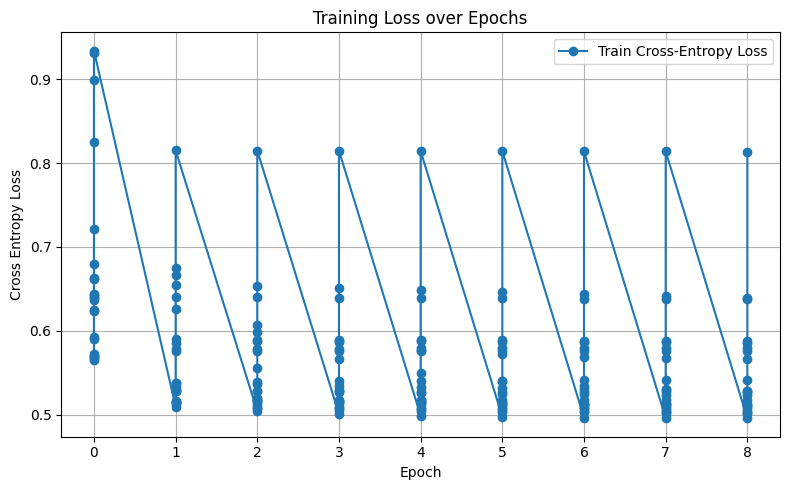

In [46]:
import boto3
import json
import matplotlib.pyplot as plt

# Define your job name
training_job_name = "linear-learner-2025-04-08-04-28-40-312"
log_group = "/aws/sagemaker/TrainingJobs"
log_stream_name = f"{training_job_name}/algo-1-1744086555"  # adjust if you used multiple containers

# Initialize CloudWatch client
logs_client = boto3.client("logs")

# Fetch logs specifically for this training job
logs = []
response = logs_client.get_log_events(
    logGroupName=log_group,
    logStreamName=log_stream_name,
    startFromHead=True
)

logs.extend(response["events"])

# If logs span multiple pages
while "nextForwardToken" in response:
    token = response["nextForwardToken"]
    response = logs_client.get_log_events(
        logGroupName=log_group,
        logStreamName=log_stream_name,
        nextToken=token,
        startFromHead=True
    )
    
    if not response["events"]:
        break
    logs.extend(response["events"])

# Parse training loss values from logs
train_loss_vals = []

for event in logs:
    msg = event["message"].strip()
    if msg.startswith("#metrics"):
        try:
            metrics_data = json.loads(msg.replace("#metrics", "").strip())
            dims = metrics_data.get("Dimensions", {})
            metrics = metrics_data.get("Metrics", {})
            epoch = dims.get("epoch")
            
            if epoch is not None and "train_multiclass_cross_entropy_objective" in metrics:
                value = metrics["train_multiclass_cross_entropy_objective"]["sum"]
                train_loss_vals.append((epoch, value))
        except Exception as e:
            continue  # Skip any malformed metric logs

# Sort by epoch
train_loss_vals.sort()
epochs = [e for e, _ in train_loss_vals]
losses = [v for _, v in train_loss_vals]

# Plot training loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, losses, marker='o', label='Train Cross-Entropy Loss')
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.title("Training Loss over Epochs")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## 27. Graphical Representation of Mean Training Losses over Epochs

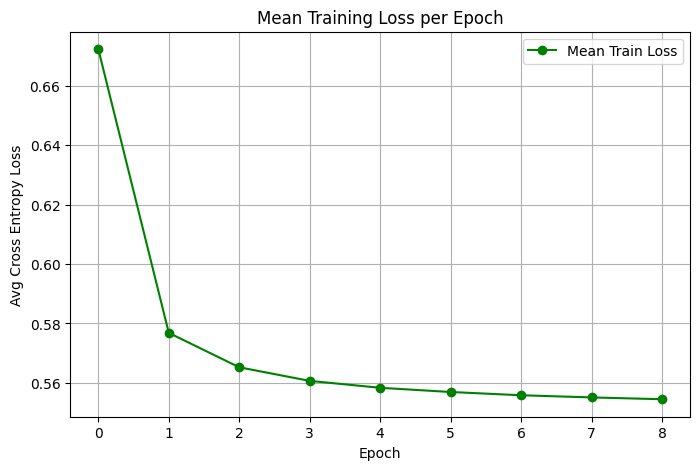

In [47]:
# Convert to DataFrame
df_loss = pd.DataFrame(train_loss_vals, columns=["epoch", "loss"])

# Compute mean loss per epoch
mean_loss_per_epoch = df_loss.groupby("epoch")["loss"].mean().reset_index()

# Plot smoothed curve
plt.figure(figsize=(8, 5))
plt.plot(mean_loss_per_epoch["epoch"], mean_loss_per_epoch["loss"], marker='o', color='green', label='Mean Train Loss')
plt.xlabel("Epoch")
plt.ylabel("Avg Cross Entropy Loss")
plt.title("Mean Training Loss per Epoch")
plt.grid(True)
plt.legend()
plt.show()


## 28. HyperParameter Tuning Job Creation

In [48]:
# 1️. Define Hyperparameter Ranges (remove epochs)
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.2),
    "mini_batch_size": IntegerParameter(32, 256),
    "wd": ContinuousParameter(0.0, 1.0),  # weight decay
    "use_bias": CategoricalParameter(['true', 'false']),  # 0 or 1 (True/False)
    "positive_example_weight_mult": ContinuousParameter(0.5, 2.0),
    "l1": ContinuousParameter(0.0, 0.5),  # L1 regularization
}

# 2️. Define Objective Metric (change to a valid metric like accuracy)
objective_metric_name = "validation:multiclass_accuracy"  # or validation:accuracy
objective_type = "Maximize"  # Maximize accuracy

# 3️. Create Hyperparameter Tuner
tuner = HyperparameterTuner(
    estimator=linear_estimator,
    objective_metric_name=objective_metric_name,
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=[
        {
            "Name": "validation:multiclass_accuracy",
            "Regex": "validation_multiclass_accuracy=([0-9\\.]+)"
        }
    ],
    objective_type=objective_type,
    max_jobs=10,  # total tuning jobs to launch
    max_parallel_jobs=2  # how many can run at once
)

# 4️. Launch Tuning Job
tuner.fit({"train": train_input, "validation": val_input})


[04/08/25 04:42:04] INFO     Creating hyperparameter tuning job with name:                          ]8;id=552287;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=666331;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#3383\3383]8;;\
                             linear-learner-250408-0442                                                            

.....................................................................................!


## 29. Extract Best Training Job among all Tuning Jobs

In [49]:
# Retrieve the best training job from the hyperparameter tuning job
best_training_job = tuner.best_training_job()

# Get the details of the best training job
print("Best Training Job:", best_training_job)


Best Training Job: linear-learner-250408-0442-009-7d428010


## 30. Metric Collection of Hyperparameter Tuned Jobs

In [50]:
# Initialize SageMaker client
sagemaker_client = boto3.client('sagemaker')

# Hyperparameter Tuning Job Name
tuning_job_name = "linear-learner-250408-0442"  # Replace with your actual tuning job name

# Get the details of the tuning job
response = sagemaker_client.describe_hyper_parameter_tuning_job(HyperParameterTuningJobName=tuning_job_name)

# Print out the structure of the response to debug
print("Response structure:", response)

# Retrieve the list of all completed training jobs in the tuning job
completed_jobs = response['BestTrainingJob']

# Print to check the content of completed_jobs
print("\n\nCompleted jobs:", completed_jobs)

# Get the job name from the 'BestTrainingJob' field
job_name = completed_jobs.get('TrainingJobName', None)
print(f"Best training job name: {job_name}")

# Proceed with further logic only if job_name is found
if job_name:
    # Create empty lists to store metrics data
    job_names = []
    log_loss_metrics = []
    accuracy_metrics = []

    # Retrieve detailed information about the training job
    job_details = sagemaker_client.describe_training_job(TrainingJobName=job_name)

    # Extract the final objective metric (accuracy)
    metrics = job_details.get('FinalHyperParameterTuningJobObjectiveMetric', {})
    accuracy = metrics.get('Value', None)

    # Append the values to the lists
    job_names.append(job_name)
    accuracy_metrics.append(accuracy)

    # Check for available metrics in FinalMetricData
    final_metrics = job_details.get('FinalMetricData', [])
    print(f"Final metrics available: {final_metrics}")

    # Check if log_loss is present in any of the metrics
    log_loss = None
    for metric in final_metrics:
        if 'log_loss' in metric.get('MetricName', '').lower():
            log_loss = metric['Value']
            break

    # Append log_loss to the list
    log_loss_metrics.append(log_loss)

    # Create a DataFrame for better visualization
    df_results = pd.DataFrame({
        'Training Job Name': job_names,
        'Log Loss': log_loss_metrics,
        'Accuracy': accuracy_metrics
    })

    # Print the DataFrame to see the results
    print(df_results)
else:
    print("No valid training job found.")


Response structure: {'HyperParameterTuningJobName': 'linear-learner-250408-0442', 'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:989629593108:hyper-parameter-tuning-job/linear-learner-250408-0442', 'HyperParameterTuningJobConfig': {'Strategy': 'Bayesian', 'HyperParameterTuningJobObjective': {'Type': 'Maximize', 'MetricName': 'validation:multiclass_accuracy'}, 'ResourceLimits': {'MaxNumberOfTrainingJobs': 10, 'MaxParallelTrainingJobs': 2}, 'ParameterRanges': {'IntegerParameterRanges': [{'Name': 'mini_batch_size', 'MinValue': '32', 'MaxValue': '256', 'ScalingType': 'Auto'}], 'ContinuousParameterRanges': [{'Name': 'learning_rate', 'MinValue': '0.001', 'MaxValue': '0.2', 'ScalingType': 'Auto'}, {'Name': 'wd', 'MinValue': '0.0', 'MaxValue': '1.0', 'ScalingType': 'Auto'}, {'Name': 'positive_example_weight_mult', 'MinValue': '0.5', 'MaxValue': '2.0', 'ScalingType': 'Auto'}, {'Name': 'l1', 'MinValue': '0.0', 'MaxValue': '0.5', 'ScalingType': 'Auto'}], 'CategoricalParameterRanges': 

## 31. Graphical Representation - Metric Analysis Across all Hypertuned Jobs

                         Training Job Name  Multiclass Accuracy  \
0  linear-learner-250408-0442-009-7d428010             0.841790   
1  linear-learner-250408-0442-006-e0e386c4             0.812126   
2  linear-learner-250408-0442-002-d42493e1             0.799375   
3  linear-learner-250408-0442-004-53c69093             0.793130   
4  linear-learner-250408-0442-008-f53746b8             0.763726   
5  linear-learner-250408-0442-001-c7f45153             0.739526   
6  linear-learner-250408-0442-003-abfd73ca             0.738486   
7  linear-learner-250408-0442-007-6912f875             0.729118   
8  linear-learner-250408-0442-010-2a194dbe             0.709081   
9  linear-learner-250408-0442-005-0f5b4d7b             0.683581   

   Best Performer  
0            True  
1           False  
2           False  
3           False  
4           False  
5           False  
6           False  
7           False  
8           False  
9           False  


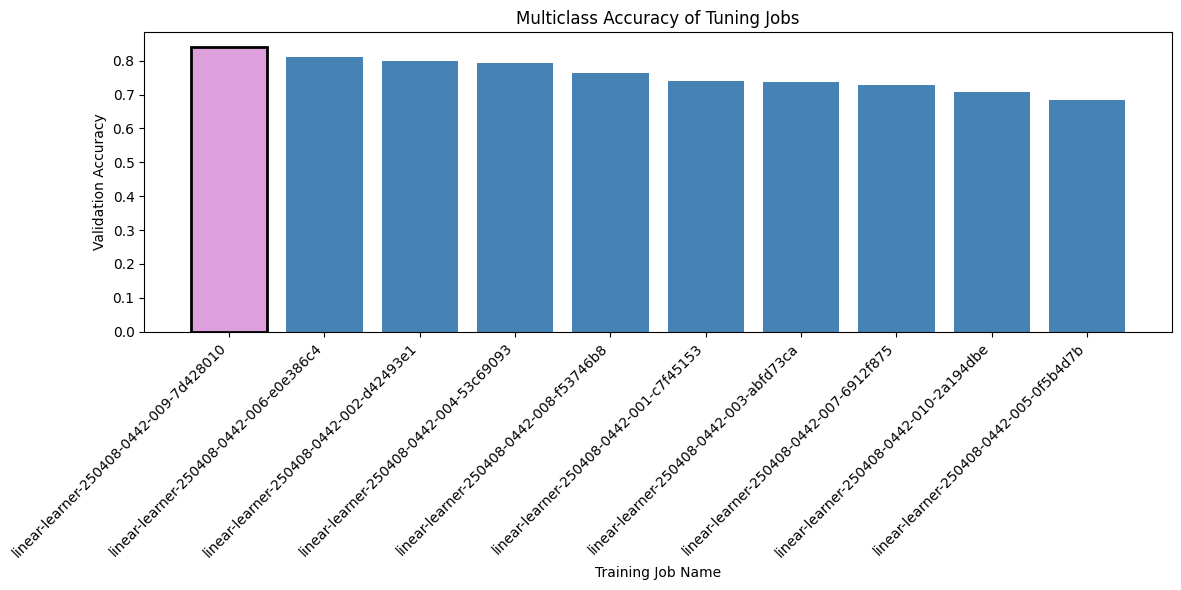

In [52]:
tuning_job_name = "linear-learner-250408-0442"

# Initialize SageMaker client
sm_client = boto3.client('sagemaker')

# Get the tuning job details
tuning_job_info = sm_client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)

# List all training jobs (correct sort)
tuning_results = sm_client.list_training_jobs_for_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name,
    SortBy="FinalObjectiveMetricValue",  # Fixed here
    SortOrder="Descending"
)

# Extract accuracy values from each job
job_metrics = []
for job_summary in tuning_results['TrainingJobSummaries']:
    job_name = job_summary['TrainingJobName']
    job_details = sm_client.describe_training_job(TrainingJobName=job_name)

    # Get metric value
    accuracy = None
    for metric in job_details.get("FinalMetricDataList", []):
        if metric["MetricName"] == "validation:multiclass_accuracy":
            accuracy = metric["Value"]
            break

    job_metrics.append({
        "Training Job Name": job_name,
        "Multiclass Accuracy": accuracy
    })

# Build and display dataframe
df_metrics = pd.DataFrame(job_metrics)
df_metrics = df_metrics.sort_values(by="Multiclass Accuracy", ascending=False).reset_index(drop=True)
df_metrics["Best Performer"] = df_metrics["Multiclass Accuracy"] == df_metrics["Multiclass Accuracy"].max()

print(df_metrics)

# Plot graph
plt.figure(figsize=(12, 6))
bars = plt.bar(df_metrics["Training Job Name"], df_metrics["Multiclass Accuracy"], color='steelblue')

# Highlight best
for i, best in enumerate(df_metrics["Best Performer"]):
    if best:
        bars[i].set_color("plum")
        bars[i].set_edgecolor("black")
        bars[i].set_linewidth(2)

plt.xticks(rotation=45, ha='right')
plt.title("Multiclass Accuracy of Tuning Jobs")
plt.xlabel("Training Job Name")
plt.ylabel("Validation Accuracy")
plt.tight_layout()
plt.show()


## 32. Best Model and its Artifact Collection

In [53]:
# Retrieve the best training job from the hyperparameter tuning job
best_training_job = tuner.best_training_job()

# Get the details of the best training job
print("Best Training Job:", best_training_job)


Best Training Job: linear-learner-250408-0442-009-7d428010


In [54]:
region = boto3.Session().region_name
sagemaker_session = sagemaker.Session()
sm_client = boto3.client("sagemaker")
role = get_execution_role()
#bucket = "project-2-drk-cloud"
model_artifact_path = f"s3://{bucket}/{s3_prefix}/{s3_sub_prefix}/linear_model/{best_training_job}/output/model.tar.gz"
model_artifact_path

's3://project-2-drk-cloud/Full-ML-Pipeline/weather-classification/linear_model/linear-learner-250408-0442-009-7d428010/output/model.tar.gz'

## 33. Model Creation

In [56]:
model_name = "weather-linear-learner-serverless-model"
image_uri = sagemaker.image_uris.retrieve("linear-learner", region=region)
model_artifact = model_artifact_path
role = get_execution_role()

model_response = sm_client.create_model(
    ModelName=model_name,
    Containers=[
        {
            "Image": image_uri,
            "Mode": "SingleModel",
            "ModelDataUrl": model_artifact
        }
    ],
    ExecutionRoleArn=role,
)

print("Model Arn: " + model_response["ModelArn"])

[04/08/25 04:53:45] INFO     Same images used for training and inference. Defaulting to image     ]8;id=889698;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=260389;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=609865;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=770621;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

Model Arn: arn:aws:sagemaker:us-east-1:989629593108:model/weather-linear-learner-serverless-model


## 34. Endpoint Configuration

In [58]:
# Endpoint configuration name
endpoint_config_name = "weather-linear-learner-serverless-endpt-config"

# Create the endpoint configuration using the Model ARN created earlier
endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,  # Name of the endpoint config
    ProductionVariants=[
        {
            "VariantName": "weather-linear-variant",  # Variant name
            "ModelName": model_name,  # Model name used in create_model
            "ServerlessConfig": {
                "MemorySizeInMB": 3072,
                "MaxConcurrency": 1,
            },  # Use serverless inference config
        }
    ]
)

# Print the endpoint config ARN
print("Endpoint Config Arn: " + endpoint_config_response["EndpointConfigArn"])

Endpoint Config Arn: arn:aws:sagemaker:us-east-1:989629593108:endpoint-config/weather-linear-learner-serverless-endpt-config


## 35. Endpoint Creation

In [59]:
# Endpoint name
endpoint_name = "weather-linear-learner-serverless-endpt"

# Create the endpoint
endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name
)

print("Endpoint ARN: " + endpoint_response["EndpointArn"])

Endpoint ARN: arn:aws:sagemaker:us-east-1:989629593108:endpoint/weather-linear-learner-serverless-endpt


Waited until the endpoint status is InService before invoking the endpoint.

## 36. Endpoint Creation - Confirmation

In [60]:
# Wait until the endpoint is in service
while True:
    endpoint_status_response = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = endpoint_status_response["EndpointStatus"]
    print(f"Endpoint status: {status}")
    
    if status == "InService":
        print("Endpoint is now in service.")
        break
    elif status == "Failed":
        print("Endpoint creation failed.")
        break
    
    # Wait before checking again
    time.sleep(30)
endpoint_status_response

Endpoint status: InService
Endpoint is now in service.


{'EndpointName': 'weather-linear-learner-serverless-endpt',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:989629593108:endpoint/weather-linear-learner-serverless-endpt',
 'EndpointConfigName': 'weather-linear-learner-serverless-endpt-config',
 'ProductionVariants': [{'VariantName': 'weather-linear-variant',
   'DeployedImages': [{'SpecifiedImage': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1',
     'ResolvedImage': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner@sha256:2e3a9eeeb8246b7f2a0438e39457ffce204e200676693566b021e31c9291cb68',
     'ResolutionTime': datetime.datetime(2025, 4, 8, 4, 54, 35, 944000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 0,
   'CurrentServerlessConfig': {'MemorySizeInMB': 3072, 'MaxConcurrency': 1}}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2025, 4, 8, 4, 54, 34, 701000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2025, 4, 8, 4, 58, 1,

## 37. Inferencing - Time Analysis with sample dataset

#### Sample 1 (1st Inference Attempt):
* Temperature_scaled: -0.277472
* Humidity: 77
* Wind Speed_scaled: 0.326923
* Precipitation (%): 18.0
* Cloud Cover: 1
* Atmospheric Pressure_zscore: 0.58665
* UV Index_clipped: 4
* Visibility_filtered: 6.0
* Season_Autumn: 0
* Season_Spring: 1
* Season_Summer: 0
* Season_Winter: 0
* Location_coastal: 1
* Location_inland: 0
* Location_mountain: 0

* Expected Weather Type: 0

#### Sample 2 (2nd Inference Attempt):
* Temperature_scaled: -1.869076
* Humidity: 24
* Wind Speed_scaled: 0.115385
* Precipitation (%): 50
* Cloud Cover: 1
* Atmospheric Pressure_zscore: 0.537269
* UV Index_clipped: 3
* Visibility_filtered: 6.5
* Season_Autumn: 0
* Season_Spring: 0
* Season_Summer: 1
* Season_Winter: 0
* Location_coastal: 0
* Location_inland: 1
* Location_mountain: 0

* Expected Weather Type: 3

In [61]:
# Create a runtime client
runtime_client = boto3.client('sagemaker-runtime')

## 37.I) 1st Inferencing

In [62]:
%%time
# 1st Sample Data (Inference Attempt 1)
first_sample_data = b"-0.277472,77,0.326923,18.0,1,0.586665,4,6.0,0,1,0,0,1,0,0"

# Expected target for 1st sample: Weather Type = 0
expected_target_1 = 0

# 1st Inference Attempt
print("1st Inference Attempt")
start_time = time.time()

# Invoke the endpoint
response_1 = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,  # Use your actual endpoint name
    Body=first_sample_data,
    ContentType="text/csv",
)

# Parse the response
end_time = time.time()
response_body = response_1['Body'].read().decode('utf-8')
response_json = json.loads(response_body)  # Convert string to JSON
predicted_label_1 = response_json['predictions'][0]['predicted_label']  # Extract predicted label

print(f"Predicted label for 1st attempt: {predicted_label_1}")
print(f"Time for 1st inference: {end_time - start_time} seconds")
print(f"Expected label for 1st attempt: {expected_target_1}")
print(f"Prediction matches expected: {predicted_label_1 == expected_target_1}")


1st Inference Attempt
Predicted label for 1st attempt: 0
Time for 1st inference: 0.40507984161376953 seconds
Expected label for 1st attempt: 0
Prediction matches expected: True
CPU times: user 18.8 ms, sys: 89 μs, total: 18.9 ms
Wall time: 406 ms


## 37.II) 2nd Inferencing

In [63]:
%%time
# 2nd Sample Data (Inference Attempt 2)
second_sample_data = b"-1.869076,24,0.115385,50.0,1,0.537269,3,6.5,0,0,1,0,0,1,0"

# Expected target for 2nd sample: Weather Type = 3
expected_target_2 = 3

# 2nd Inference Attempt
print("\n2nd Inference Attempt")
start_time = time.time()

# Invoke the endpoint
response_2 = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,  # Use your actual endpoint name
    Body=second_sample_data,
    ContentType="text/csv",
)

# Parse the response
end_time = time.time()
response_body_2 = response_2['Body'].read().decode('utf-8')
response_json_2 = json.loads(response_body_2)  # Convert string to JSON
predicted_label_2 = response_json_2['predictions'][0]['predicted_label']  # Extract predicted label

print(f"Predicted label for 2nd attempt: {predicted_label_2}")
print(f"Time for 2nd inference: {end_time - start_time} seconds")
print(f"Expected label for 2nd attempt: {expected_target_2}")
print(f"Prediction matches expected: {predicted_label_2 == expected_target_2}")



2nd Inference Attempt
Predicted label for 2nd attempt: 0
Time for 2nd inference: 0.08165168762207031 seconds
Expected label for 2nd attempt: 3
Prediction matches expected: False
CPU times: user 4.45 ms, sys: 2.26 ms, total: 6.71 ms
Wall time: 86.2 ms


## 38. Entire Dataset - Inferencing

In [68]:
# Setup for SageMaker runtime client
runtime_client = boto3.client('runtime.sagemaker')

# S3 Paths for training and testing data (if necessary)
#bucket_name = "project-2-drk-cloud"
s3_client = boto3.client('s3')

# Load your data from S3 or locally
data = pd.read_csv("test_linear.csv")  # Use your actual CSV file path

# Feature columns and target column
features = [
    'Temperature_scaled', 'Humidity', 'Wind Speed_scaled', 'Precipitation (%)', 'Cloud Cover',
    'Atmospheric Pressure_zscore', 'UV Index_clipped', 'Visibility_filtered',
    'Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Winter', 
    'Location_coastal', 'Location_inland', 'Location_mountain'
]
target = 'Weather Type'

# Prepare the inference data (only features, not the target)
inference_data = data[features]

# Initialize lists to store predictions and actual labels
predicted_labels = []
actual_labels = data[target].tolist()

# Variable to store total time taken for all inferences
total_inference_time = 0

# Perform inference for all rows in the dataset
for row_data in inference_data.values:
    # Convert the row data to CSV format and encode as bytes
    input_data = ",".join(map(str, row_data)) + "\n"
    input_data = input_data.encode('utf-8')
    
    # Start time for inference
    start_time = time.time()

    # Perform inference
    response = runtime_client.invoke_endpoint(
        EndpointName='weather-linear-learner-serverless-endpt',  # Replaced with actual endpoint name
        Body=input_data,
        ContentType="text/csv"
    )

    # End time for inference
    end_time = time.time()

    # Extract the prediction from the response (which is in JSON format)
    prediction = response['Body'].read().decode('utf-8')
    prediction_json = json.loads(prediction)
    predicted_label = prediction_json['predictions'][0]['predicted_label']
    
    # Append the predicted label to the list
    predicted_labels.append(predicted_label)
    
    # Add the inference time for this prediction to the total time
    total_inference_time += (end_time - start_time)


## 39. Metric Data - on Inferencing Entire Dataset 


Accuracy: 84.18%
Average time per inference: 0.0387 seconds


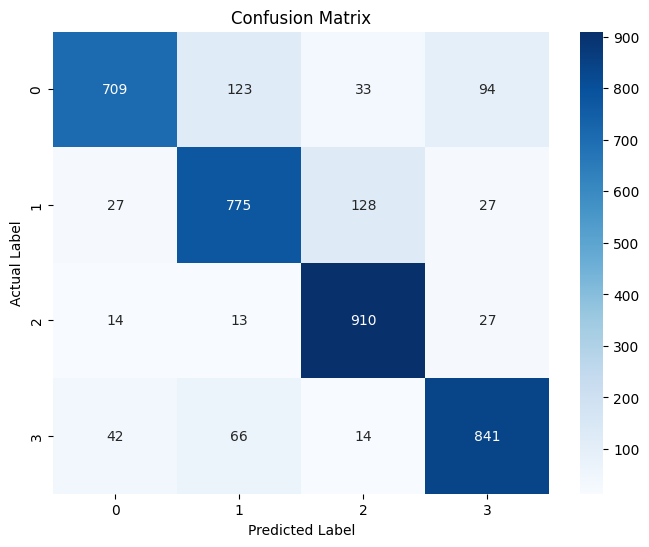

              precision    recall  f1-score   support

           0       0.90      0.74      0.81       959
           1       0.79      0.81      0.80       957
           2       0.84      0.94      0.89       964
           3       0.85      0.87      0.86       963

    accuracy                           0.84      3843
   macro avg       0.84      0.84      0.84      3843
weighted avg       0.84      0.84      0.84      3843



In [69]:
# Calculate the accuracy of the model on the dataset
accuracy = accuracy_score(actual_labels, predicted_labels)

# Calculate the average time per inference
average_inference_time = total_inference_time / len(inference_data)

# Print results
print(f"\nAccuracy: {accuracy * 100:.2f}%")
print(f"Average time per inference: {average_inference_time:.4f} seconds")

# Create a confusion matrix for the predictions
cm = confusion_matrix(actual_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2, 3], yticklabels=[0, 1, 2, 3])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.show()

# Print the classification report (optional)
from sklearn.metrics import classification_report
print(classification_report(actual_labels, predicted_labels))


## 40. Endpoint Deletion

In [71]:
import boto3

# Initialize the SageMaker client
sagemaker_client = boto3.client('sagemaker')

# Replace with your actual endpoint name
endpoint_name = 'weather-linear-learner-serverless-endpt'

# Delete the endpoint
try:
    print(f"Deleting endpoint {endpoint_name}...")
    sagemaker_client.delete_endpoint(EndpointName=endpoint_name)
    print(f"Endpoint {endpoint_name} deleted successfully.")
except Exception as e:
    print(f"Error deleting endpoint: {str(e)}")


Deleting endpoint weather-linear-learner-serverless-endpt...
Endpoint weather-linear-learner-serverless-endpt deleted successfully.


### 41. Serverless Endpoint Screenshots

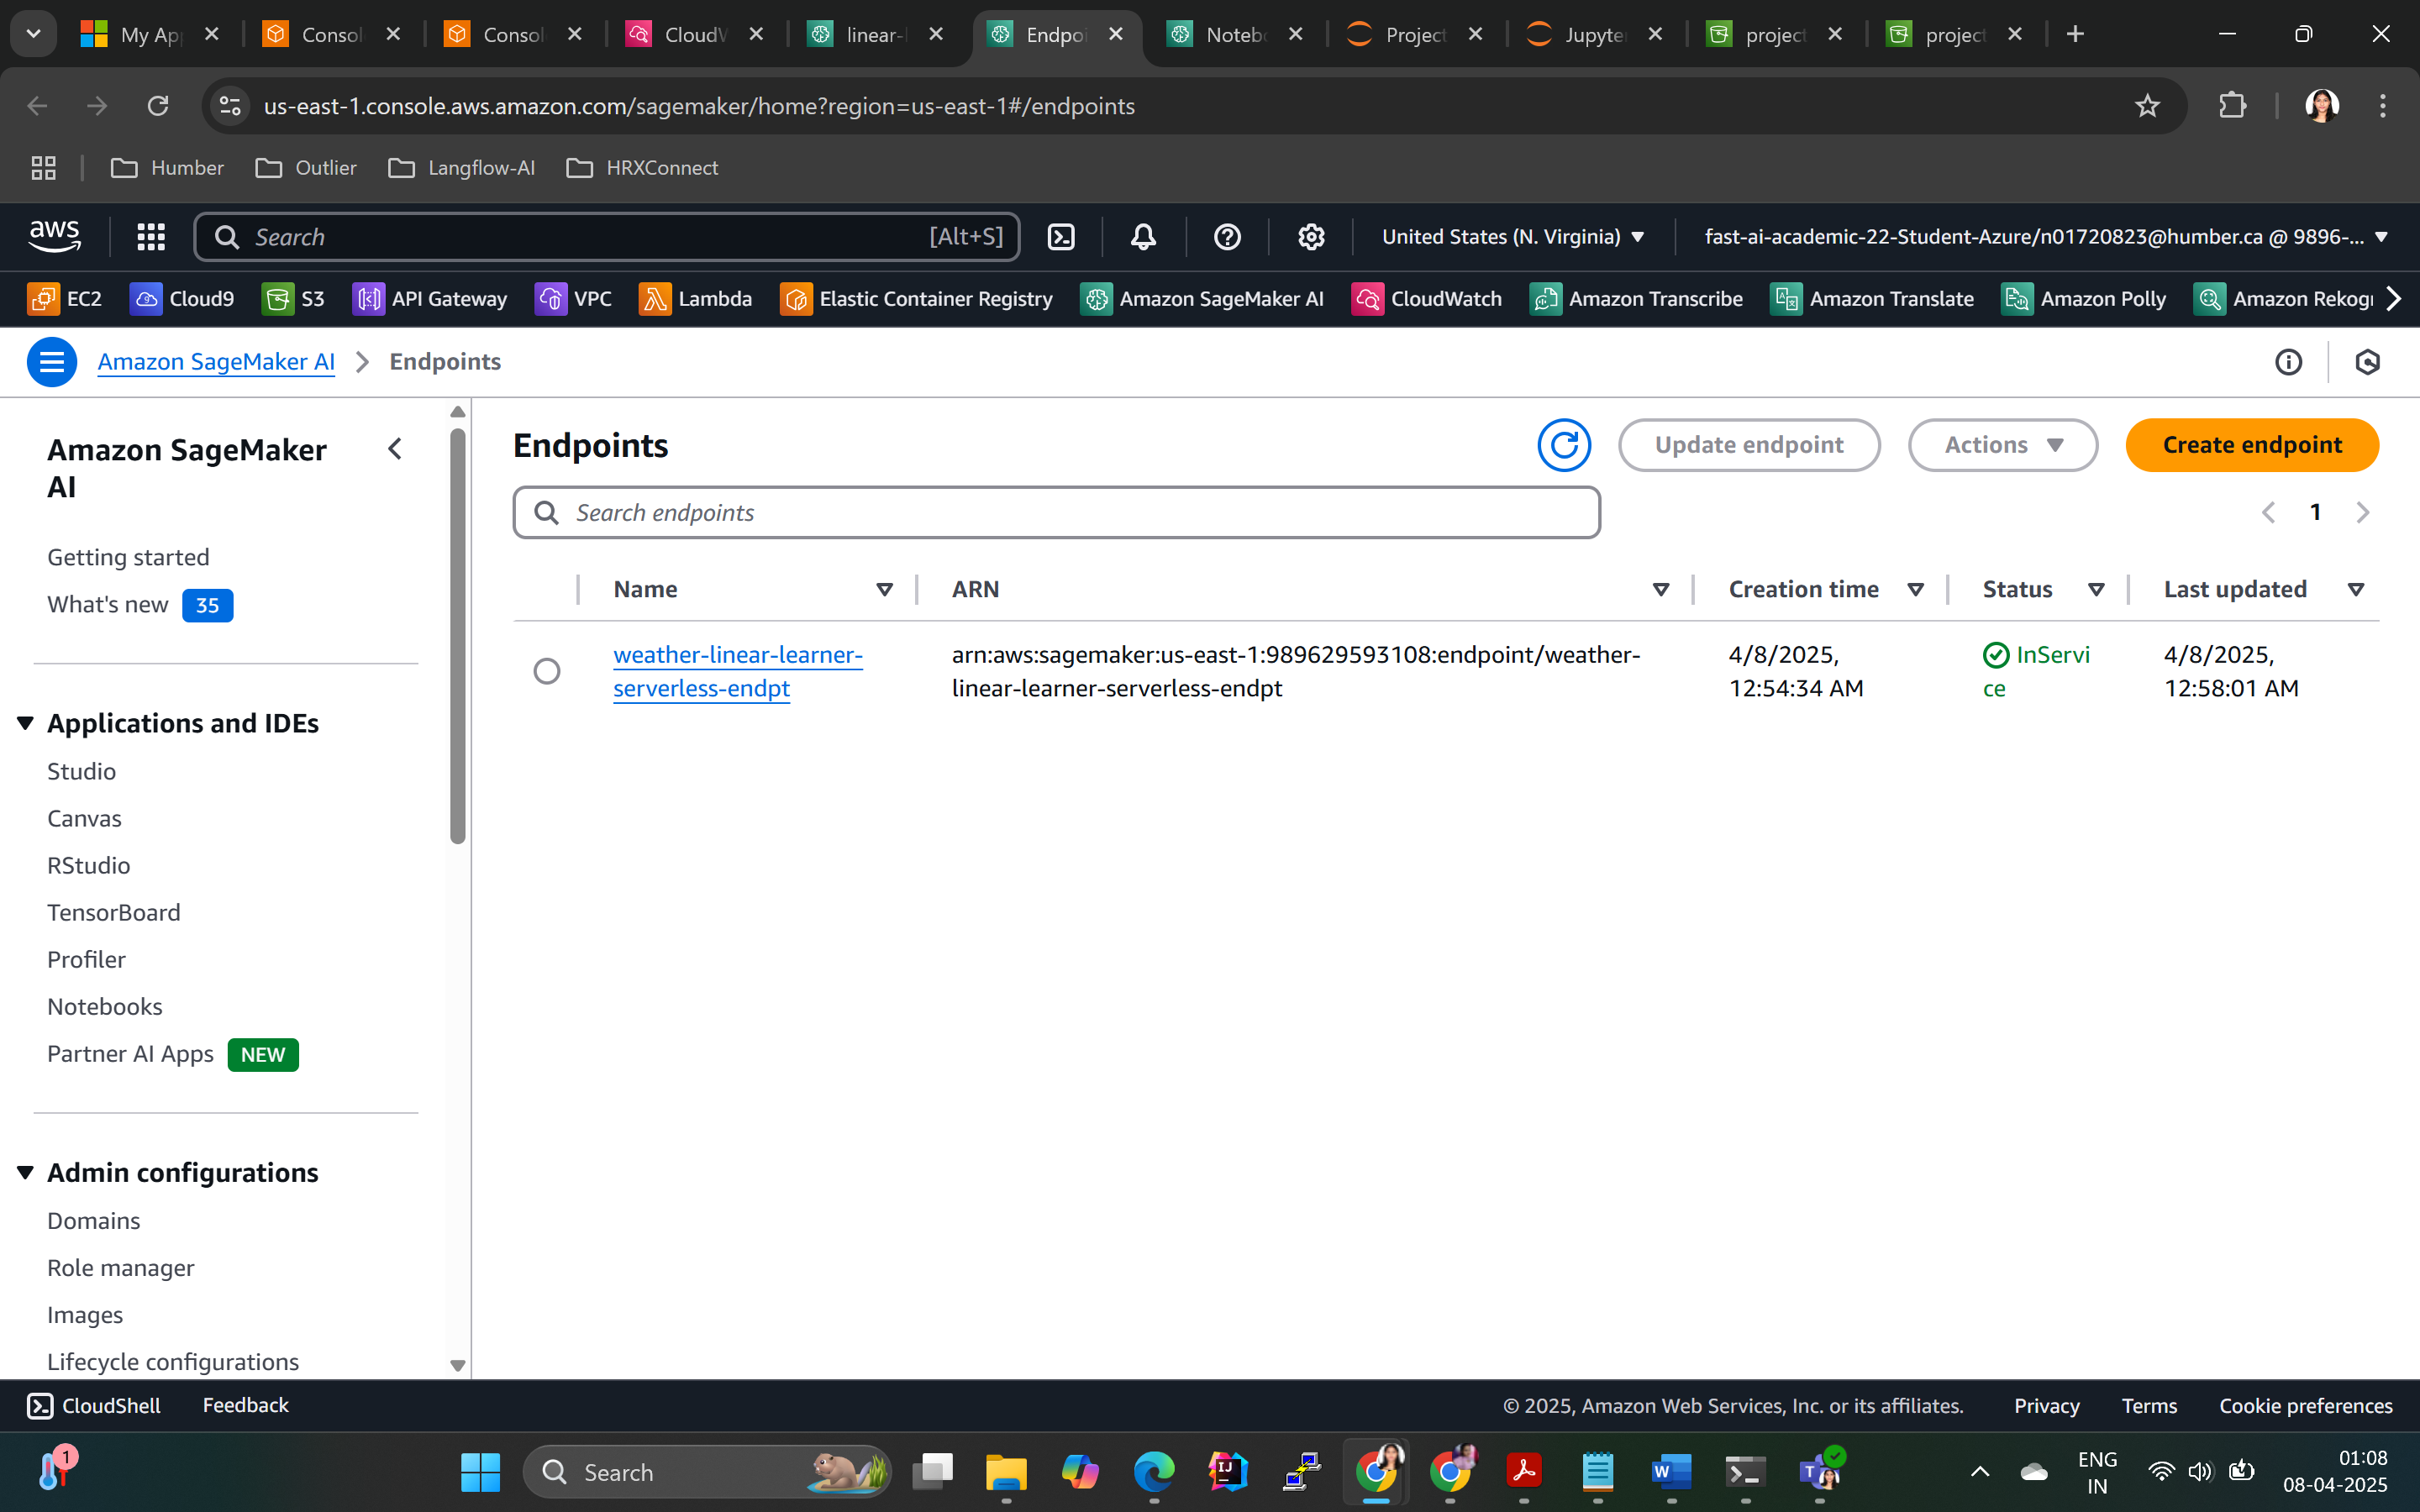

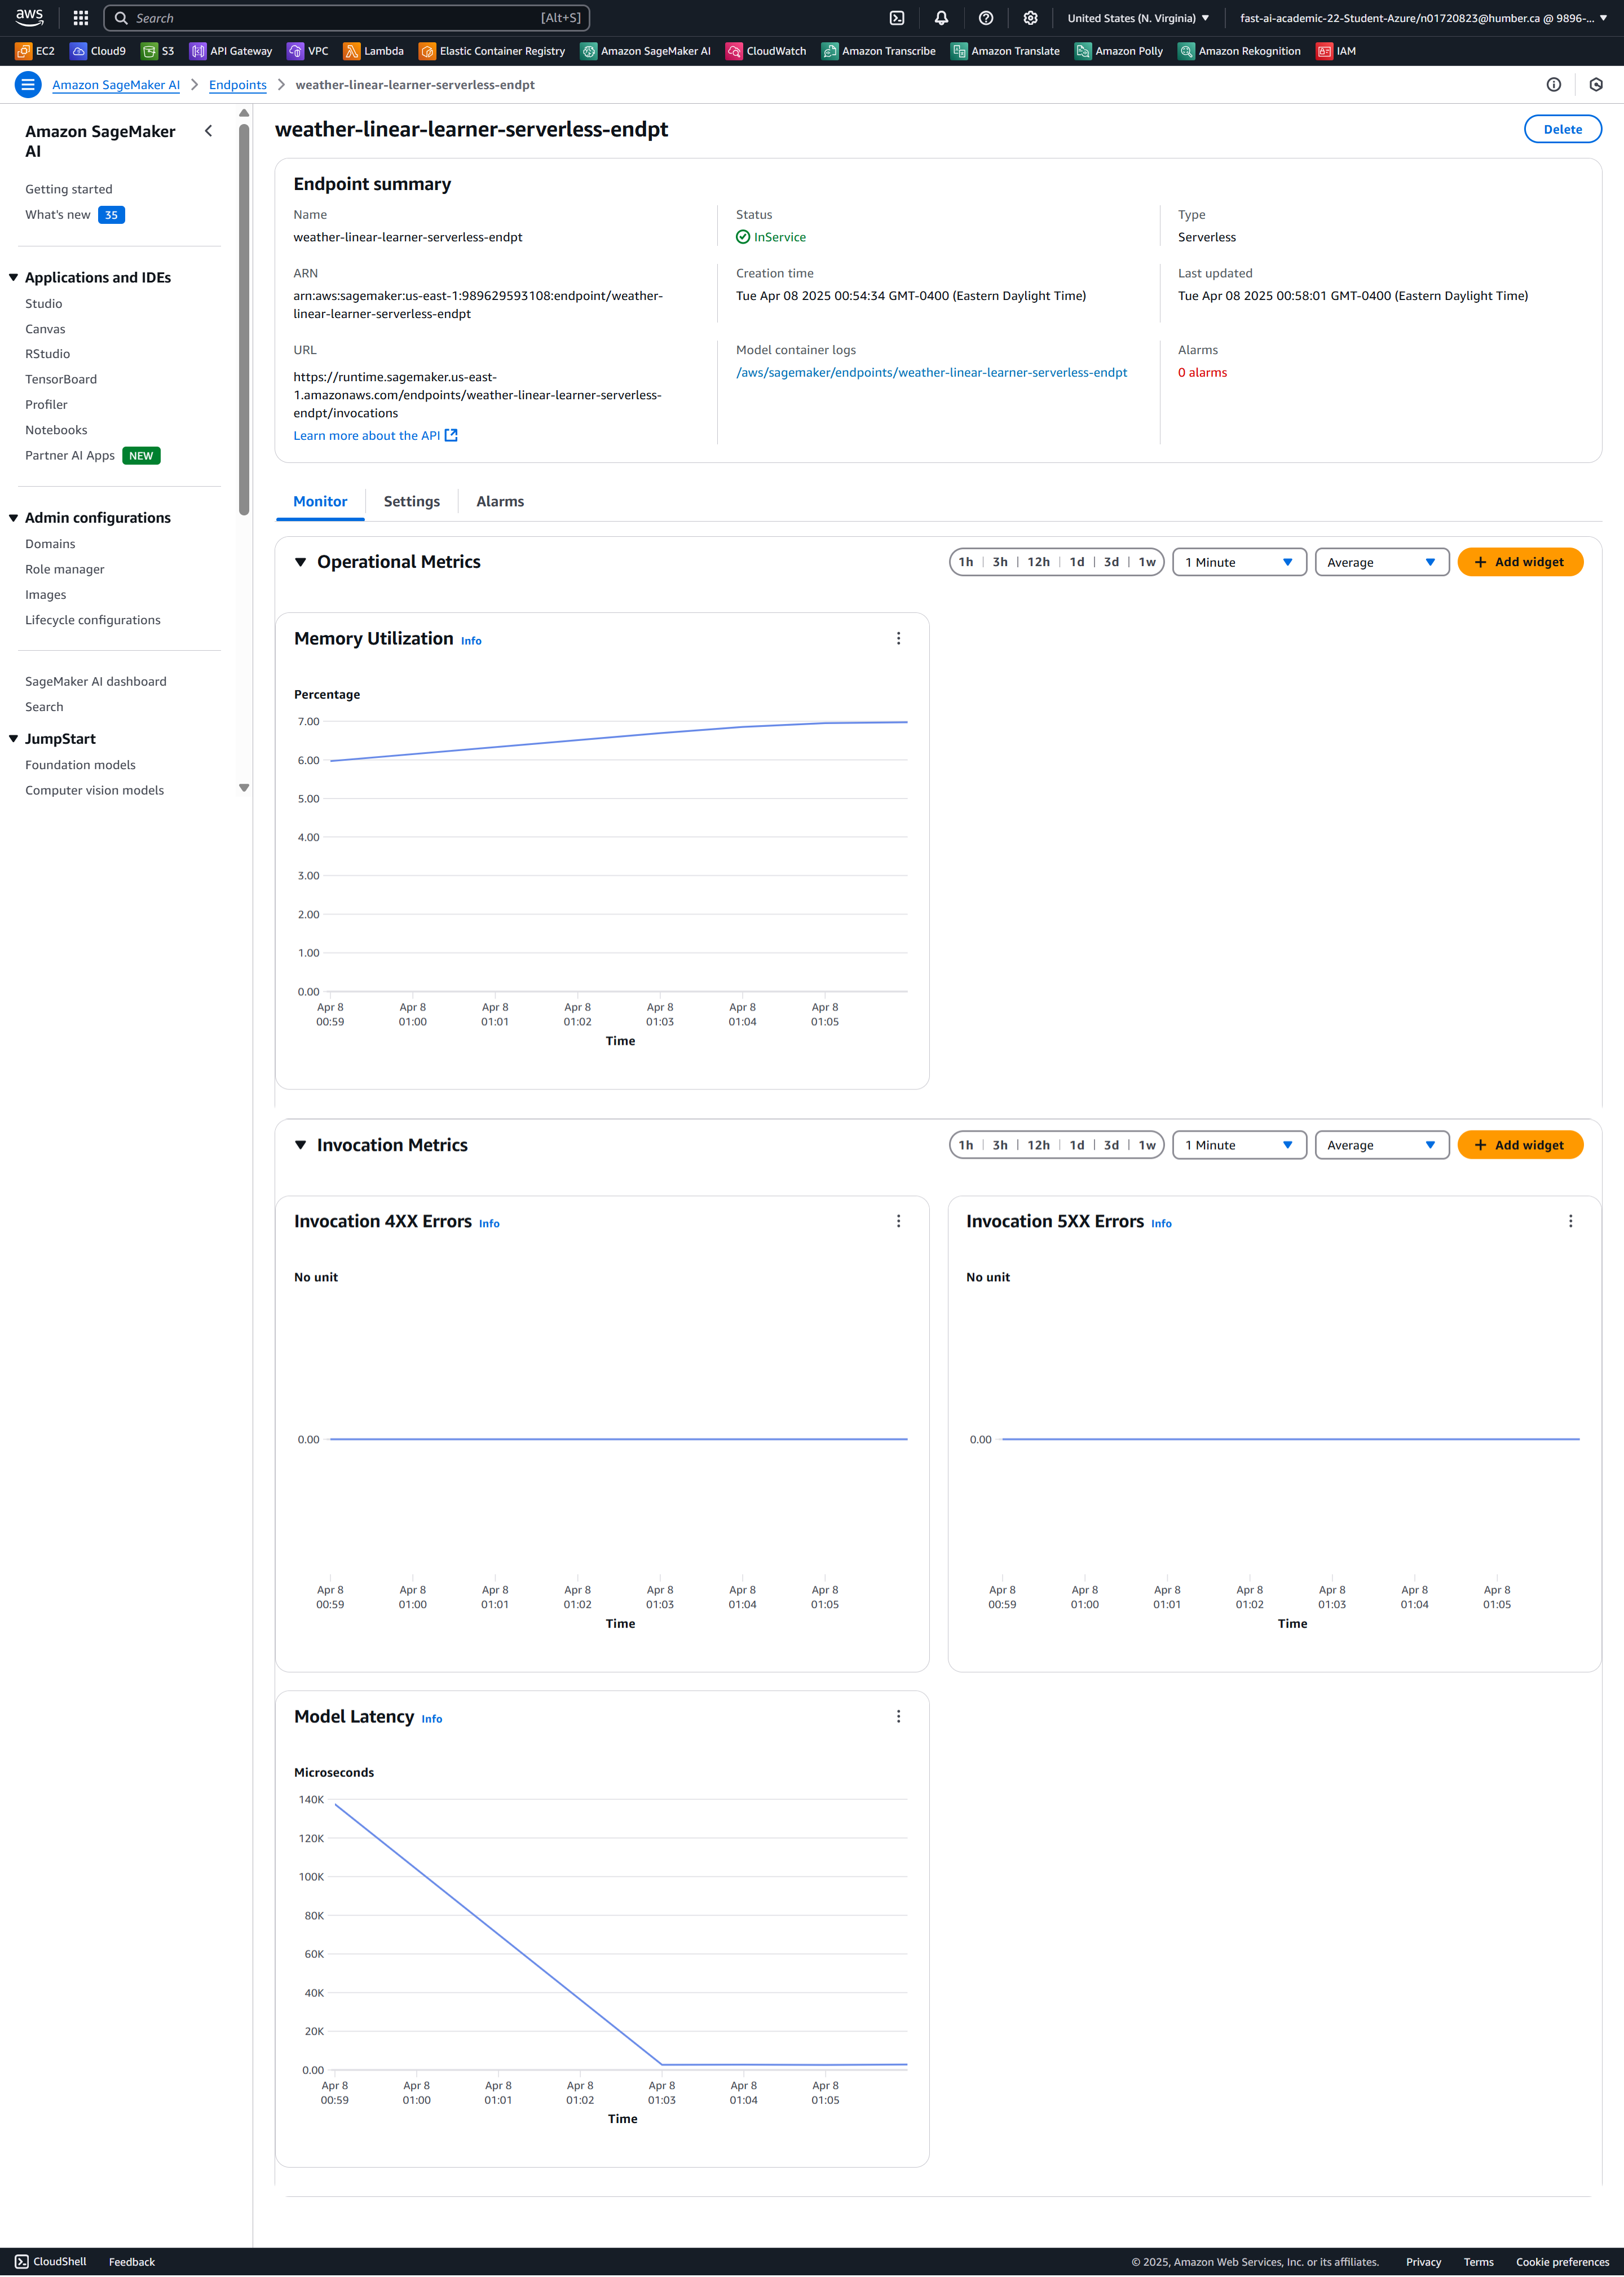